<a href="https://colab.research.google.com/github/anonynousICAILsubmision2023/AIFairness_EUlaw/blob/main/Experimental_setup_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIF360 bias metrics

## Import packages, connect to google drive and load the algorithms that compute measures

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math

# adjust path to import datasets
path = '/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa/Datasets/'

# read arff file
import sys
try:
  import arff
except ModuleNotFoundError:
 !pip install liac-arff
 import arff

import sys
sys.path.append('/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa')

try:
  import aif360
except ModuleNotFoundError:
  !pip install 'aif360[OptimPreproc]'
  import aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=ce18530d55fe92219f75df8a99e1b965c724c1fbf70c49624386b8d86dbcfc47
  Stored in directory: /root/.cache/pip/wheels/a2/de/68/bf3972de3ecb31e32bef59a7f4c75f0687a3674c476b347c14
Successfully built liac-arff
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 KB 15.5 MB/s eta 0:00:00


For more information about the AIF360 toolkit that is launched by IBM Research Trusted AI refer to the [toolkit guide and demo](https://aif360.mybluemix.net/) and the [documentation](https://aif360.readthedocs.io/en/latest/index.html).

In [ ]:
import copy
from aif360.sklearn.datasets import standardize_dataset 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score, classification_report, make_scorer, accuracy_score, precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
encode = True

pip install 'aif360[LawSchoolGPA]'


Links to functions, documentation, papers and mathematics:  
- [Statistical parity difference](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.sklearn.metrics.statistical_parity_difference.html#aif360.sklearn.metrics.statistical_parity_difference): Related papers are [Learning Fair Representations](http://proceedings.mlr.press/v28/zemel13.pdf), [Fairness through awareness](https://dl.acm.org/doi/pdf/10.1145/2090236.2090255)
- [Disparate Impact Ratio](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.sklearn.metrics.disparate_impact_ratio.html#aif360.sklearn.metrics.disparate_impact_ratio): Related papers are [Certifying and Removing Disparate Impact](https://dl.acm.org/doi/pdf/10.1145/2783258.2783311),
- [Equal opportunity difference](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.sklearn.metrics.equal_opportunity_difference.html#aif360.sklearn.metrics.equal_opportunity_difference): Related papers are  [Fairness Definitions Explained](https://ieeexplore.ieee.org/abstract/document/8452913)
- Average odds difference: Related papers are [Poisoning Attacks on Algorithmic
Fairness](https://link.springer.com/content/pdf/10.1007/978-3-030-67658-2.pdf?pdf=button) and [Equality of Opportunity in Supervised Learning](https://proceedings.neurips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf)

**TO-DOs** 

Add Smoothed empirical differential fairness (EDF) from [here](https://aif360.readthedocs.io/en/latest/modules/sklearn.html#group-fairness-metrics). Also, add individual fairness metrics. For synthetic datasets, check out this one: https://arxiv.org/pdf/2010.03986.pdf - Note that this is not published yet.  hyperparameter optimization too. 


**Pre-training metrics** 

I came upon this concept following this [towardsdascience blogpost](https://towardsdatascience.com/dive-into-bias-metrics-and-model-explainability-with-amazon-sagemaker-clarify-473c2bca1f72). It is based on the journal publication: [LiFT: A Scalable Framework for Measuring Fairness in ML Applications](https://dl.acm.org/doi/abs/10.1145/3340531.3412705) (Vasudevan & Kenthapadi, 2020). There is the related [Lift library](https://github.com/linkedin/LiFT/blob/main/dataset-fairness.md) on github. I am going to use their functions. Basically, they are descriptive statistics used to assess representativeness, label distribution and imbalances across subgroups (Vasudevan & Kenthapadi, 2020) which may be likely to lead to a biased model. Their goal is to report the extent to which training
data is representative across different subgroups. These refer to a desired (benchmark) distribution and the training data. For benchmarking, oversampling, undersampling or a mix of both might be in order, i.e. the benchmark dataset is necessarily the given dataset. I would like to add a crossvalidation component here. 

In scholar google, I came upon the following paper that mention this term.

In [ ]:
from aif360.sklearn.metrics import statistical_parity_difference,disparate_impact_ratio,equal_opportunity_difference,average_odds_difference, kl_divergence
def average_odds_difference(y_true, y_pred, priv_group, pos_label):
  
  # merge true and predictions such that they share the same index (prot)
  cm = pd.DataFrame(y_true)
  cm['y_pred'] = y_pred

  # choose unpriviledged based on index and priv_group
  underpriv = cm.loc[cm.index != priv_group, :]
  ct_underpriv = confusion_matrix(underpriv['Y_test'].values, 
                                  underpriv['y_pred'].values, 
                                  labels = underpriv['Y_test'].unique())
  ct_underpriv = pd.DataFrame(ct_underpriv, 
                              index = underpriv['Y_test'].unique(), 
                              columns = underpriv['Y_test'].unique())
  FPR_underpriv = sum(ct_underpriv.loc[:,pos_label][ct_underpriv.loc[:,pos_label].index != pos_label]) / sum(underpriv['Y_test'] != pos_label)
  TPR_underpriv = sum(ct_underpriv.loc[:,pos_label][ct_underpriv.loc[:,pos_label].index == pos_label]) / sum(underpriv['Y_test'] == pos_label)

  # choose priviledged based on index and priv_group
  priv = cm.loc[cm.index == priv_group, :]
  ct_priv = confusion_matrix(priv['Y_test'].values, 
                                  priv['y_pred'].values, 
                                  labels = priv['Y_test'].unique())
  ct_priv = pd.DataFrame(ct_priv, 
                              index = priv['Y_test'].unique(), 
                              columns = priv['Y_test'].unique())
  FPR_priv = sum(ct_priv.loc[:,pos_label][ct_priv.loc[:,pos_label].index != pos_label]) / sum(priv['Y_test'] != pos_label)
  TPR_priv = sum(ct_priv.loc[:,pos_label][ct_priv.loc[:,pos_label].index == pos_label]) / sum(priv['Y_test'] == pos_label)

  return ((FPR_underpriv - FPR_priv) + (TPR_underpriv - TPR_priv))/2

def equal_opportunity_difference(y_true, y_pred, priv_group, pos_label):
  
  # merge true and predictions such that they share the same index (prot)
  cm = pd.DataFrame(y_true)
  cm['y_pred'] = y_pred

  # choose unpriviledged based on index and priv_group
  underpriv = cm.loc[cm.index != priv_group, :]
  ct_underpriv = confusion_matrix(underpriv['Y_test'].values, 
                                  underpriv['y_pred'].values, 
                                  labels = underpriv['Y_test'].unique())
  ct_underpriv = pd.DataFrame(ct_underpriv, 
                              index = underpriv['Y_test'].unique(), 
                              columns = underpriv['Y_test'].unique())
  TPR_underpriv = sum(ct_underpriv.loc[:,pos_label][ct_underpriv.loc[:,pos_label].index == pos_label]) / sum(underpriv['Y_test'] == pos_label)

  # choose priviledged based on index and priv_group
  priv = cm.loc[cm.index == priv_group, :]
  ct_priv = confusion_matrix(priv['Y_test'].values, 
                                  priv['y_pred'].values, 
                                  labels = priv['Y_test'].unique())
  ct_priv = pd.DataFrame(ct_priv, 
                              index = priv['Y_test'].unique(), 
                              columns = priv['Y_test'].unique())
  TPR_priv = sum(ct_priv.loc[:,pos_label][ct_priv.loc[:,pos_label].index == pos_label]) / sum(priv['Y_test'] == pos_label)

  return TPR_underpriv - TPR_priv

Conditional demographic parity ([Wachter et al. 2021](https://www.sciencedirect.com/science/article/pii/S0267364921000406?casa_token=IAHqySd2ZqUAAAAA:K6PBkzXHqeAdcGXfaG4HFqeJwU44L_oaCEjOjjodqj45jHR8mR2J1evy1Gg1Od_C_qPIKc9p#cit_274)). Similar to ([Kamiran et al., 2013](https://link.springer.com/article/10.1007/s10115-012-0584-8)). Wachter et al. (2021) mention the term "protected class" which I am not sure what it refers to: I think it refers to the negative label in the target. Also, R refers to several conditions. We need to set these conditions per dataset and based on literature and legal/ethical criteria. Therefore, I cannot make a function before specifying this.

In [ ]:
def group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class = True, classifier = 'Random forest', encode = True):        
  '''
  Computes group fairness metrics
  Arguments:
    df: pandas dataframe, a data table comprising all variables plus the target
    target: string, classification target, can be both binary or multiclass
    prot: string, selected protected feature, cannot be more than two
    pos_label: string, the class or label of the target that is the best classification outcome, required by AIF360 functions
    priv_group: string, priviledged group within the protected feature, required by AIF360 functions
    metrics_results: pandas dataframe, global variable, should be initialized before running the algorithm, concatenates the metric results
    classifier: sting, best classifier based on hyperparameter optimization
    encode: min
  '''

  data = copy.deepcopy(df)
  X,y = standardize_dataset(data, prot_attr=prot, target = target)

  if remove_prot_from_class:
    X.pop(prot)

  baseline = y.value_counts(normalize=True).iloc[0] # to do's use majority class as baseline, is this applicable to multiclass? to-fix

  if encode == True:
      # min max normalization
      X_enc = copy.deepcopy(X)

      try:
        scaler = MinMaxScaler()
        X_enc[X_enc.select_dtypes(exclude='object').columns] = scaler.fit_transform(X_enc.select_dtypes(exclude='object'))
      except ValueError:
        pass  

      # dummy variables
      dummies = pd.get_dummies(X_enc.select_dtypes(include='object'), drop_first=True)
      X_enc.drop(X_enc.select_dtypes(include='object').columns,axis=1, inplace=True)
      X_enc[dummies.columns] = dummies.values

  y_enc = copy.deepcopy(y)
  if y.dtypes in ['object']:
      # encode target variable as number because 
      enc = LabelEncoder()
      y_enc = enc.fit_transform(data[target])

  if encode == False: # not sure why I do this
      X_enc = copy.deepcopy(X)

  X_train, X_test, Y_train, Y_test = train_test_split(X_enc, y_enc, stratify=y, test_size=0.3, random_state=0)

  model = RandomForestClassifier(random_state=0).fit(X_train, Y_train) # to do's use the best classifier per dataset

  y_pred = model.predict(X_test)
  test_accuracy = model.score(X_test, Y_test)
  y_preb_probs = model.predict_proba(X_test)

  if pd.Series(Y_test).value_counts().shape[0] == 2:
      y_preb_probs = y_preb_probs[:, 1]
      AUC = roc_auc_score(Y_test, y_preb_probs)
  else:
      AUC =  roc_auc_score(Y_test, y_preb_probs, average="weighted", multi_class="ovr")

  _,_,fscore,_=score(Y_test,y_pred,average='weighted')

  if y.dtypes in ['object']:
      X_test['Y_test'] = enc.inverse_transform(Y_test)
      X_test['Y_pred'] = enc.inverse_transform(y_pred)
  else:
      X_test['Y_test'] = Y_test
      X_test['Y_pred'] = y_pred

  statistical_parity = np.round(statistical_parity_difference(X_test['Y_test'], X_test['Y_pred'], prot_attr=prot, pos_label=pos_label, priv_group=priv_group),2)
  disparate_impact = np.round(disparate_impact_ratio(y_true= X_test['Y_test'], y_pred = X_test['Y_pred'], prot_attr=prot, pos_label=pos_label, priv_group=priv_group),2)
  average_odds = np.round(average_odds_difference(X_test['Y_test'], X_test['Y_pred'], priv_group, pos_label),2)
  equal_opportunity = np.round(equal_opportunity_difference(X_test['Y_test'], X_test['Y_pred'], priv_group, pos_label),2)
  kl_div, info = compute_kl_div(X_test['Y_pred'], pos_label, neg_label, priv_group, unpriv_group, class_order)

  results = pd.DataFrame(np.array([dataset, target, prot, priv_group, pos_label, statistical_parity, 
                        disparate_impact, average_odds, equal_opportunity,  kl_div, np.round(baseline,2), np.round(test_accuracy,2), np.round(AUC,2), classifier, not remove_prot_from_class]).reshape((1,-1)), columns=cols)
  metrics_results = pd.concat([metrics_results, results], ignore_index = True)
  return results, metrics_results, info

**About KL divergence**

When the target variable and/or the protected feature have more than two classes, such as `score_text` and `race` for COMPAS, then KL divergence as [coded by AIF360](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.sklearn.metrics.kl_divergence.html) does not work. It measures the difference between two distributions - for example: females who received the loan and males who received the loan.

To handle such scenarios, I wrapped AIF360 kl divergence function in another function that binarizes the target/prot feature in all possible ways: i.e. if `score_text` has three classes: `[Low, Medium, High]`, I binarize it in two ways: (i) `[Low, Medium], [High]` and (ii) `[Low], [Medium, High]` and report the respective kl divergence. Moreover, if the protected attribute has more than two values, I binarize it in one way. In the case of `race`,  given that `Caucasian` represents the priviledged, unprotected group, and `Black` or `Africa-American` the unpriviledged, protected one: I compute the measure based only these two groups, and ignore the rest.

Nevertheles, I disagree with the way the KL divergence is computed by AIF360 or [Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-kl-divergence.html). See the definition [in this paper](https://arxiv.org/pdf/2008.07433.pdf). It is the diffence between an observed and a desired distribution. Why would you use the the distribution of the unprivileged group as a desired benchmark? According to this [source](http://hanj.cs.illinois.edu/cs412/bk3/KL-divergence.pdf)), 
typically p(x) represents the “true” distribution of data. Q(x) typically represents a theory, model, description, or approximation of p(x). Therefore, I believe that q(x) is the ideal distribution which in my opinion should be 0.5. Of all the people who received a loan, half of them are men and the other half are women, or the relevant proportion of men and women in the sample. I created my own function that does that. The user needs to specify the idea q(x). Initially, I created my own function to be able to hadle multiclass and multi-values variables. It's in the Supplementary material and, in the future, might revert back to it. Some relevant links: (i) https://github.com/linkedin/LiFT/blob/main/dataset-fairness.md, (ii) https://towardsdatascience.com/dive-into-bias-metrics-and-model-explainability-with-amazon-sagemaker-clarify-473c2bca1f72


In [ ]:
# compute kl divergence from AIF360 as pre-training metric
def compute_kl_div(target_with_prot_in_index, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True):

  y_true = target_with_prot_in_index

  kl = []
  info = []

  #
  window = len(class_order)-1
  labels = [pos_label, neg_label]
  for idx, item in enumerate(class_order):
    if (window + idx) > len(class_order):
      break
    else:
      group = class_order[idx:idx+window]
      split = [item for item in class_order if item not in class_order[idx:idx+window]][0]
      labels.remove(split)

      binary_target = y_true.where(y_true == split, labels[0])

      if binarize_protected:
        new_index = {item:priv_group for item in binary_target.index.unique() if item != unpriv_group}
        binary_target = binary_target.rename(index=new_index)

      kld = kl_divergence(
          y_true = binary_target[(binary_target.index == priv_group) ^ (binary_target.index == unpriv_group)], y_pred = None,
          priv_group=priv_group)
      kl.append(round(kld,2))
      info.append(str([group, 'grouped as:', labels[0], 'remaining label:' ,split, 'protected feature binary', binarize_protected]))

    labels = [pos_label, neg_label]
  return kl, info

In [ ]:
cols = ['Dataset', 'Target', 'Protected', 'Priviledged group', 'Positive label',
                        'Stat. parity', 'Disp. impact', 'Av. odds', 'Equal opp.', 'KL_div', 'Baseline', 'Test_accuracy', 'AUC','Classifier', 'Prot in X']
metrics_results = pd.DataFrame(columns = cols)

## Dutch Census

The decision feature is occupation based on [add studies]. It has two distinct values: `2_1` which should stand for *Professionals* and `5_4_9` which should be *Service workers and shop and market sales workers*. An issue with this dataste is that I cannot find any description of the features. Suggeting to not use this dataset at all. It was retrieved from [taiequy's github account](https://github.com/tailequy/fairness_dataset). The related paper is [A survey on datasets for fairness-aware machine learning](https://wires.onlinelibrary.wiley.com/doi/10.1002/widm.1452).

In [ ]:
# Dutch census
df = pd.DataFrame(arff.load(open(path+'dutch_census_2001.arff', 'r'))['data']) 
attributes = arff.load(open(path+'dutch_census_2001.arff', 'r'))['attributes']
attributes = {item[0]: item[1:] for item in attributes}
df.columns = attributes.keys()

dataset = 'Dutch'
target = 'occupation'
prot = 'sex' # or `sex`, `age`, `country of birth`
priv_group = '1'
unpriv_group = '2'
pos_label = '2_1' # `2_1` or `5_4_9` 
neg_label = '5_4_9'
class_order = ['5_4_9', '2_1'] # from positive to negative

In [ ]:
df.head()

,sex,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,Marital_status,occupation
0,1,6,1131,112,1,1,1,5,111,135,1,2_1
1,2,10,1122,113,1,1,1,2,111,122,2,5_4_9
2,1,8,1122,113,1,1,1,2,111,122,2,2_1
3,1,12,1121,112,1,1,1,1,111,137,2,5_4_9
4,2,4,1110,114,1,1,1,2,111,138,1,5_4_9


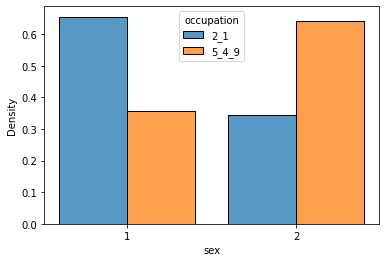

In [ ]:
sns.histplot(x = 'sex', hue='occupation', data = df, multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.show()

In [ ]:
pd.crosstab(df['occupation'].values, columns=df['sex'].values, 
            rownames=['occupation'], colnames=['sex'], normalize='index')

sex,1,2
occupation,,
2_1,0.655704,0.344296
5_4_9,0.356540,0.643460


`Age` is coded using numbers between 4 and 15. These might correspond to a YYYY format. For example, 4 might be 1984...

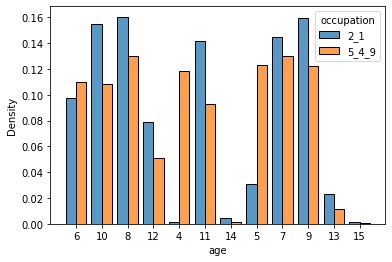

In [ ]:
sns.histplot(x = 'age', hue='occupation', data = df, multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.show()

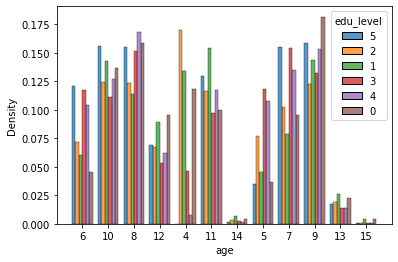

In [ ]:
sns.histplot(x = 'age', hue='edu_level', data = df, multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.show()

In [ ]:
y = df[target]
y.index = df[prot]

compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

([0.19, 0.19],
 ["[['5_4_9'], 'grouped as:', '5_4_9', 'remaining label:', '2_1', 'protected feature binary', True]",
  "[['2_1'], 'grouped as:', '2_1', 'remaining label:', '5_4_9', 'protected feature binary', True]"])

In [ ]:
#CDD (Wachter et al. 2021) - we need to specify the conditional attribute R - here I will condition on the marital status
R = 'Marital_status'

sizes = pd.DataFrame(df.groupby([R,target,prot]).size(), columns = ['Number'])
sizes['Rate'] = round(sizes / sizes.groupby([target,R]).transform('sum'),2)
sizes.reset_index().pivot(index = R, columns = [target,prot], values = ['Rate','Number'])

ValueError: ignored

In [ ]:
results, metrics_results, _ = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order)
results

In [ ]:
results, metrics_results, _ = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class = False)
results

## COMPAS & CDD

Different works have prepared the data differently. Violent recidivism problem is not included to simpify the analysis. 

The meaning of each feature in the dataset is explained [here](https://rpubs.com/omesner/survival)

- `two_year_recid`: I think that the is whether or not offenders actually committed a crime based on Propublica's research and not NorthPoint's. This could be the ground truth but I am not sure. According to ProPublica's analysis "it is a numeric indicator of whether the defendant recidivated two years after previous charge."

- `decile score`: Is a measuring made by COMPAS. `score_text` is actually based based on `decile score`. If does not make sense to use both in our analysis. Refer to [ Northpoint's guide](https://www.equivant.com/wp-content/uploads/Practitioners-Guide-to-COMPAS-Core-040419.pdf) for more clarity. 

- `is_recid`: Is a predictor.

- `score_text`: Is a y variable, same as `decile.score.1` but with different granularity.

I include four different versions of the dataset because I am not sure which one is most suitable for our case. These are loaded and preprocesed below:

### 1st version of COMPAS dataset. 

I copied the preprocessing as made by Propublica in section `Loading the Data`, code snippets 2, 3 and 4 which can be found [here](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb). Their methodology can be found [here](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). Note that their methodology was never published in conference preceedings or journals.

In [ ]:
# ProPublica dataset -- the analysis is here: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
df = pd.read_csv(path+'compas-scores-two-years.txt', index_col=0)

df = df[(df['days_b_screening_arrest'] <= 30) & 
   (df['days_b_screening_arrest'] >= -30) & 
   (df['is_recid'] != -1) &
   (df['c_charge_degree'] != 'O') &
   (df['score_text'] != 'N/A')]

df['length_of_stay'] = pd.to_datetime(df['c_jail_in'].str.slice(0, 10)) - pd.to_datetime(df['c_jail_out'].str.slice(0, 10))
df['length_of_stay'] = df['length_of_stay'].dt.days

# Follow propublica analysis, did not use Age_cat
df = df.loc[:,['age','c_charge_degree', 'race', 'sex', 'priors_count',
                'days_b_screening_arrest', 'length_of_stay', 
               'is_recid', 'two_year_recid']] # 'decile_score', 'two_year_recid', 'score_text', 
df['two_year_recid'] = np.where(df['two_year_recid'] == 0, 'No recid.', 'Did recid.')

In [ ]:
df = pd.read_csv(path+'compas-scores-two-years.txt', index_col=0)
df['two_year_recid'] = np.where(df['two_year_recid'] == 0, 'No recid.', 'Did recid.')
df.columns

Index(['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age',
       'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date',
       'c_arrest_date', 'c_days_from_compas', 'c_charge_degree',
       'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree',
       'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in',
       'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

Measures are computed below after specifyig the appropriate `target`, `prot` feature, `pos_label` within the target and `priv_group` within the `prot`. These are required by AIF360 to compute the metrics. Finally, I arbitrarily name the `dataset` such that I can properly identify it. Metrics are computed and then added to the `results` data table along with the results of other datasets.

In [ ]:
df['score_text'].value_counts()

Low     3421
High    2751
Name: score_text, dtype: int64

In [ ]:
#df['score_text'] = df['score_text'].replace('Medium', 'Low')

dataset = 'Propublica' # 'withscore_text'
target =  'two_year_recid' #'score_text' or 'two_year_recid'
prot = 'race' # sex or race
pos_label = 'No recid.' #'Low' or 0 or No recid.
priv_group =  'Caucasian' # 'Caucasian' or 'Female'
unpriv_group = 'African-American' # 'Male' or 'African-American'
neg_label = 'Did recid.'#'High' or 1
class_order = ['No recid.', 'Did recid.'] # 'No recid.', 'Did recid.' 'Low', 'High'

In [ ]:
#CDD (Wachter et al. 2021) - we need to specify the other attributes R - here I will condition on the race or sex
if prot == 'sex':
  R = 'race'
else:
  R = 'sex'

sizes = pd.DataFrame(df.groupby([R,target,prot]).size(), columns = ['Number'])
sizes['Rate'] = round(sizes / sizes.groupby([target,R]).transform('sum'),2)
sizes = sizes.reset_index().pivot(index = R, columns = [target,prot], values = ['Rate','Number'])

sizes.T

In [ ]:
y = df[target]
y.index = df[prot]

print(prot)
compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

In [ ]:
y = df[target]
y.index = df[prot]

print(prot)
compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

COMPAS metrics results do not align with Celis results.

In [ ]:
# medium & high
results, metrics_results, info = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class=False)
results

,Dataset,Target,Protected,Priviledged group,Positive label,Stat. parity,Disp. impact,Av. odds,Equal opp.,KL_div,Baseline,Test_accuracy,AUC,Classifier,Prot in X
0,Propublica,score_text,race,Caucasian,Low,-0.19,0.73,-0.13,-0.08,"[0.17, 0.17]",0.55,0.74,0.82,Random forest,True


In [ ]:
# medium & low
results, metrics_results, info = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class=False)
results

,Dataset,Target,Protected,Priviledged group,Positive label,Stat. parity,Disp. impact,Av. odds,Equal opp.,KL_div,Baseline,Test_accuracy,AUC,Classifier,Prot in X
0,Propublica,score_text,race,Caucasian,Low,-0.13,0.87,-0.14,-0.07,"[0.1, 0.1]",0.81,0.83,0.8,Random forest,True


In [ ]:
from sklearn.model_selection import StratifiedKFold
y = df['two_year_recid'].values.flatten()
X = df[df.columns[:-1]].values
skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"Fold {i}:")
  #print(f"  Train: index={df.iloc[train_index[0]:,].shape}")
  #print(f"  Test:  index={df.iloc[test_index[0]:,].shape}")
  results_train, metrics_results, info = group_metrics(df.iloc[train_index[0]:,], target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class=False)
  results_test, metrics_results, info = group_metrics(df.iloc[test_index[0]:,], target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class=False)
  print('train',results_train['Disp. impact'].values, 'test',results_test['Disp. impact'].values)

Fold 0:
train [0.8] test [0.83]
Fold 1:
train [0.83] test [0.8]
Fold 2:
train [0.83] test [0.79]
Fold 3:
train [0.83] test [0.82]
Fold 4:
train [0.83] test [0.71]


In [ ]:
results, metrics_results, info = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class=False)
results

,Dataset,Target,Protected,Priviledged group,Positive label,Stat. parity,Disp. impact,Av. odds,Equal opp.,KL_div,Baseline,Test_accuracy,AUC,Classifier,Prot in X
0,Propublica,two_year_recid,race,Caucasian,No recid.,-0.1,0.83,-0.0,0.01,"[0.05, 0.05]",0.54,0.97,0.97,Random forest,True


What about including the protected attribute when training the classifier? This can be done by setting parameter `remove_prot_from_class` equal to `False.`

In [ ]:
results, metrics_results = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results)
results

### 2nd version of COMPAS dataset. 

I copied the preprocessing as made by Propublica in section `Predictive Accuracy of COMPAS`, code snippet 31 which can be found again [here](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb). Propublica claims that is followed the same methodology as in [Northpoints' validation study](https://journals.sagepub.com/doi/abs/10.1177/0093854808326545). Target here is `score_text`. They regress `Start`, `End`, `Event` on `score_text`.

In [ ]:
# Northpoint cox-parsed dataset as provided by Propublica -- add link
dataset = 'cox_parsed'

df = pd.read_csv(path+'cox-parsed.txt')
df.drop(df['score_text'][df['score_text'].isna()].index, axis=0, inplace=True) # drop rows where `score_text` is NA
df.drop(df[df.end < df.start].index, axis=0, inplace=True) # drop end that is bigger than start
df.drop_duplicates(subset=['id'], inplace=True) # drop duplicates

# meausre length betweeen dates
df['length_of_stay_c'] = pd.to_datetime(df['c_jail_in'].str.slice(0, 10)) - pd.to_datetime(df['c_jail_out'].str.slice(0, 10))
df['length_of_stay_c'] = df['length_of_stay_c'].dt.days.fillna(0)
df['length_of_stay_r'] = pd.to_datetime(df['r_jail_in'].str.slice(0, 10)) - pd.to_datetime(df['r_jail_out'].str.slice(0, 10))
df['length_of_stay_r'] = df['length_of_stay_r'].dt.days.fillna(0)
df['length_of_custody'] = pd.to_datetime(df['in_custody'].str.slice(0, 10)) - pd.to_datetime(df['out_custody'].str.slice(0, 10))
df['length_of_custody'] = df['length_of_custody'].dt.days.fillna(0)

# drop columns that do not have predictive power and anything related to violent recid.
dropcols = ['name', 'first', 'last', 'compas_screening_date', 
            'dob', 'age_cat', 'c_case_number', 'c_offense_date', 
            'c_arrest_date', 'c_days_from_compas','c_charge_desc', 'c_jail_in', 
            'c_jail_out', 'r_case_number', 'r_charge_desc', 'r_jail_in', 'r_offense_date',
            'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number',
            'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'screening_date',
            'v_type_of_assessment', 'v_decile_score', 'v_score_text','v_screening_date',
            'in_custody', 'out_custody', 'decile_score.1', 'priors_count.1', 'decile_score']

df.drop(dropcols, axis=1, inplace=True)

# fillnas because classifiers cannot handle them
df.vr_charge_degree.fillna('Unknown', inplace=True)
df.r_days_from_arrest.fillna(0, inplace=True)
df.r_charge_degree.fillna('Unknown', inplace=True)
df.c_charge_degree.fillna('Unknown', inplace=True)
df.days_b_screening_arrest.fillna(0, inplace=True)

df.index = df['id'].values
df.drop(['id'], axis=1, inplace=True)

Measures are computed below after specifyig the appropriate `target`, `prot` feature, `pos_label` within the target and `priv_group` within the `prot`. These are required by AIF360 to compute the metrics. Finally, I arbitrarily name the `dataset` such that I can properly identify it. Metrics are computed and then added to the `results` data table along with the results of other datasets.

In [ ]:
import seaborn as sb
corr = df.corr()
plt.figure(figsize = (16,5))
sb.heatmap(corr, cmap="Blues", annot=True, )

In [ ]:
target = 'score_text'

# place the target in the last column
df[target] = df.pop(target)

prot = 'race' # sex or race
pos_label = 'Low'
priv_group =  'Caucasian' # 'Caucasian' or 'Female'
unpriv_group = 'African-American' # 'Male' or 'African-American'
neg_label = 'High'
class_order = ['Low', 'Medium', 'High'] # frop negative to positive

In [ ]:
#CDD (Wachter et al. 2021) - we need to specify the other attributes R - here I will condition on the race or sex
if prot == 'sex':
  R = 'race'
else:
  R = 'sex'

sizes = pd.DataFrame(df.groupby([R,target,prot]).size(), columns = ['Number'])
sizes['Rate'] = round(sizes / sizes.groupby([target,R]).transform('sum'),2)
sizes = sizes.reset_index().pivot(index = R, columns = [target,prot], values = ['Rate','Number'])

sizes

In [ ]:
y = df[target]
y.index = df[prot]

print(prot)
compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

In [ ]:
y = df[target]
y.index = df[prot]

print(prot)
compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

In [ ]:
results, metrics_results, _ = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order)
results

What about including the protected attribute when training the classifier? This can be done by setting parameter `remove_prot_from_class` equal to `False.`

In [ ]:
results, metrics_results = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, remove_prot_from_class=False)
results

### 3rd version of Compas dataset - WE WILL GO WITH THIS ONE

Dataset description can be found [here](https://farid.berkeley.edu/downloads/publications/scienceadvances17/readme.txt), note that `BROWARD_CLEAN` version is used. The csv file can be found [here](https://farid.berkeley.edu/downloads/publications/scienceadvances17/). The related publication is [The accuracy, fairness, and limits of predicting recidivism](https://www.science.org/doi/10.1126/sciadv.aao5580). According to Dressel & Farid (2018), seven of these columns were used. These are `'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'charge_id' and 'charge_degree (misd/fel)`. Note that `race` was removed from the algorithmic and human prediction.  

We have three potential targets, i.e. the last three columns. I will not predict `compas_decile_score` because, first, it is not explored in the paper and, second, it is a continuous. I will use both `two_year_recid` and `compas_guess` as target. The former reprsents the ground truth (which is already reporting a higher recidivism rate for black people) and the latter COMPAS's predictive power.

In [ ]:
# Broward_Clean
df = pd.read_csv(path+'BROWARD_CLEAN.csv')
two_year_recid = df['two_year_recid']
compas_guess = df['compas_guess']
df = df.loc[:,df.columns[:-4]]
df['sex'] = df.sex.replace({0: 'Male', 1: 'Female'})
compas_guess_text = df.compas_guess.replace({0: 'Did not recidivate', 1: 'Recidivated'})
df['race'] = df.race.replace({1: 'Caucasian', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native American', 6: 'Other'})

#df.drop(['compas_decile_score'], axis=1, inplace=True)
df.set_index(['id'], inplace=True) # for FRU, race should be retained.

numeric = [False, False, True, True, True, True, False, False, False, False]
dtype_dic = {col:'object' if not dtype else 'int64' for dtype, col in zip(numeric, df.columns)}
df = df.astype(dtype_dic)

In [ ]:
# baselines
print(two_year_recid.value_counts(normalize='all').round(2)) 
compas_guess.value_counts(normalize='all').round(2)

0    0.55
1    0.45
Name: two_year_recid, dtype: float64


0    0.54
1    0.46
Name: compas_guess, dtype: float64

For meta-classifier, should all features be binary and dummy coded??

In [ ]:
#df = pd.read_csv(path+'BROWARD_CLEAN.csv', index_col='id')
#df = df.loc[:,df.columns[:-4]]
#df['sex'] = df.sex.replace({0: 'Male', 1: 'Female'})
#df['race'] = df.race.replace({1: 'Caucasian', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native American', 6: 'Other'})
#df['compas_guess'] = df.compas_guess.replace({0: 'No recid.', 1: 'Did recid.'})
#df['two_year_recid'] = df.two_year_recid.replace({0: 'No recid.', 1: 'Did recid.'})

#df.to_csv(path+'BROWARD_CLEAN2.csv')

Measures are computed below after specifyig the appropriate `target`, `prot` feature, `pos_label` within the target and `priv_group` within the `prot`. These are required by AIF360 to compute the metrics. Finally, I arbitrarily name the `dataset` such that I can properly identify it. Metrics are computed and then added to the `results` data table along with the results of other datasets.


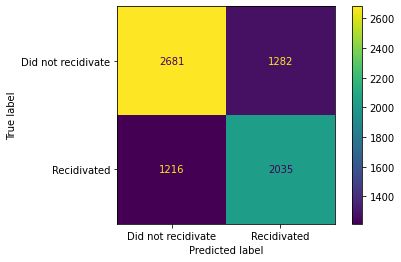

In [ ]:
cm_display = metrics.confusion_matrix(y_true = df['two_year_recid'].astype('int'), y_pred = df['compas_guess'].astype('int')) # , normalize='all'
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_display, display_labels = ['Did not recidivate', 'Recidivated'])
cm_display.plot()
plt.show()

### CDD

We decided that the explainable feature `R` will be `priors_count`. `priors_count` is numeric ranging from 0 to 38. Its statistics are presented below:

In [ ]:
df['priors_count'].describe()

CDD is more interpretable when there are limited values within `R`. Therefore, we discretized `priors_count` based on the table below:

In [ ]:
pd.crosstab(df['priors_count'],df['two_year_recid'],normalize='index') # 2,8

If a person has less than 3 priors, then the priors count is considered to be `low`. If a person has between 3-8 priors, then the priors count is considered to be `medium`. Finally, if a person has more than 8 priors, then the priors count is `high`. We can still change this 

In [ ]:
new_list = []
for i in df[['priors_count']].values.flatten():
  if i==0:
    new_list.append('low priors')
  if (i >= 1) and (i <=3):
    new_list.append('medium priors')
  if i > 3:
    new_list.append('high priors')

priors_count_threshold = np.array(new_list)

Compare the two targets `compas guess` with `two_year_recid`.

In [ ]:
data = pd.DataFrame([two_year_recid.values, compas_guess.values, df['sex'].values, df['race'].values, priors_count_threshold]).T
data.columns = ['two_year_recid', 'compas_guess', 'sex', 'race', 'Priors threshold']

Association between R and Y

In [ ]:
Ys = ['two_year_recid', 'compas_guess']
Rs = ['Priors threshold']

from scipy.stats import chi2_contingency

for Y in Ys:
  print('Compute strength of association between', Y, 'with', Rs[0])
  statistic, pvalue, dof, expected_freq  = chi2_contingency(pd.crosstab(data[Y], data[Rs[0]]))
  significance = 'significant 'if pvalue < 0.05 else 'non-significant'
  print('chi2 statistic:', np.round(statistic,2), 'with a p-value of', np.round(pvalue,3), 'means that the association is',significance, 'dof', dof)

  X2  = chi2_contingency(pd.crosstab(data[Y], data[Rs[0]]))[0]
  N = len(df)
  minimum_dimension = min(df.shape)-1
  result = np.sqrt((X2/N) / minimum_dimension)
  association_strength = 'weak' if result < 0.10 else 'moderate' if ((result >= 0.10) & (result < 0.15)) else 'strong' 
  print("Cramer's V:", np.round(result,2), 'means that the association is', association_strength)
  print(' ')

Compute strength of association between two_year_recid with Priors threshold
chi2 statistic: 572.92 with a p-value of 0.0 means that the association is significant  dof 2
Cramer's V: 0.09 means that the association is weak
 
Compute strength of association between compas_guess with Priors threshold
chi2 statistic: 996.66 with a p-value of 0.0 means that the association is significant  dof 2
Cramer's V: 0.12 means that the association is moderate
 


Cdd

There is correlation but weak according to chi-squared statistic and Cramer's V association coeddicient.

In [ ]:
cdd_sizes = {}
Rs = ['Priors threshold']
Ys = ['two_year_recid', 'compas_guess']
prots = ['sex', 'race']

for Y in Ys:
  cdd_sizes[Y] = {}
  for prot in prots:
    cdd_sizes[Y][prot] = {}
    for R in Rs:
      
      cdd_data = pd.DataFrame(np.array([data[Y].values, data[R], data[prot]]).T, columns = ['Label', R, prot])

      sizes = pd.DataFrame(cdd_data.groupby([prot,'Label',R]).size(), columns = ['Number '+Y])
      sizes['Rate '+Y] = round(sizes / sizes.groupby(['Label',R]).transform('sum'),2)
      cdd_sizes[Y][prot][R] = pd.DataFrame(sizes)

In [ ]:
cdd = {}
for Y in Ys:
  cdd[Y] = {}
  for R in Rs:
    cdd[Y][R] = {}
    for prot in prots:
      pivot = cdd_sizes[Y][prot][R].reset_index().pivot(columns = ['Label', prot], index = R, values = ['Rate '+Y])
      cdd_row = []
      for pair in pivot.columns:
        group_label = pd.DataFrame(pivot[pair[0]][pair[1]][pair[2]])
        
        weights = pd.DataFrame(np.unique(data[R], return_counts=True)).T
        weights.columns = [R, 'Weights']
        weights.set_index(R, inplace = True)

        group_label['Weights'] = weights['Weights']
        group_label.fillna(0, inplace=True)

        cdd_agg = round(sum(group_label[pair[2]] * group_label['Weights']) / len(data[R]),2)
        cdd_row.append(cdd_agg)

        #print(cdd_agg, end = ' | ')
        #print(pair[1:])
      pivot.loc['All'] = np.array(cdd_row)
      cdd[Y][R][prot] = pivot

In [ ]:
all_cdd = {}
all_cdd['compas'] = {}

compare = pd.DataFrame(cdd[Ys[0]][Rs[0]]['sex'].iloc[-1,:]).T
compare.index = [Ys[0]]
compare.loc[Ys[1], :] = pd.DataFrame(cdd[Ys[1]][Rs[0]]['sex'].iloc[-1,:]).T.values
compare

all_cdd['compas']['sex'] = compare

Protected feature `sex`
- Compas guess (predictions made by Northpoint's system):
    - Among people who were classified as 'will not recidivate' (positive label), 19% of them were females. Among people who were classified as 'will recidivate' (negative label), 20% of them were females. According to CDD, these two percentages should be balanced which is the case, therefore, Northpoint's prediction are not biased in favor of females. 
    - Among people who were classified as 'will not recidivate' (positive label), 81% of them were males. Among people who were classified as 'will recidivate' (negative label), 80% of them were also males which means that Northpoint's prediction are not biased against males.
    
Let us see what actually happened based on Propublica's data. 

- Target: two_year_recid (Propublica's data about who actually recidivated):
    - Among people who 'did not recidivate' (positive label), 48% of them were black. Among people who 'recidivated' (negative label), 56% of them were black. This is slightly more balanced than Northpoint's predictions which means that in reality less black people are likely to recommit a crime. 
    - Among people who 'did not recidivate' (positive label), 36% of them were white. Among people who 'did recidivate' (negative label), 31% of them were white. The same relationship is observed in the rest of the ethnic groups as well. This means than in reality, more white people reoffended compared to Northpoint's predictions. The same goes for Hispanic people and Other ethnicities.

In other words, reality is slightly more balanced.

In [ ]:
compare = pd.DataFrame(cdd[Ys[0]][Rs[0]]['race'].iloc[-1,:]).T
compare.index = [Ys[0]]
compare.loc[Ys[1], :] = pd.DataFrame(cdd[Ys[1]][Rs[0]]['race'].iloc[-1,:]).T.values
compare

all_cdd['compas']['race'] = compare

Protected feature `race`
- Compas guess (predictions made by Northpoint's system):
    - Among people who were classified as 'will not recidivate' (positive label), 41% of them were black. Among people who were classified as 'will recidivate' (negative label), 63% of them were black. According to CDD, these two percentages should be balanced. This comparison represents $D_{R} > A_{R}$ in Wachter et al. page. 56. 
    - Among people who were classified as 'will not recidivate' (positive label), 41% of them were white. Among people who were classified as 'will recidivate' (negative label), 27% of them were white. The same relationship is observed in the rest of the ethnic groups as well.
    
In other words, there is bias in favor of white people and against black people according to cdd. Let us see what actually happened based on Propublica's data. 

- Target: two_year_recid (Propublica's data about who actually recidivated):
    - Among people who 'did not recidivate' (positive label), 48% of them were black. Among people who 'recidivated' (negative label), 56% of them were black. This is slightly more balanced than Northpoint's predictions which means that in reality less black people are likely to recommit a crime. 
    - Among people who 'did not recidivate' (positive label), 36% of them were white. Among people who 'did recidivate' (negative label), 31% of them were white. The same relationship is observed in the rest of the ethnic groups as well. This means than in reality, more white people reoffended compared to Northpoint's predictions. The same goes for Hispanic people and Other ethnicities.

In other words, reality is slightly more balanced and fair, but still black people are slightly more likely to reoffend. This might be related to substantive equality.


### Other metrics

In [ ]:
df.drop(['two_year_recid'], axis=1, inplace=True) # retain either `two_year_recid` or `compas_guess`

dataset = 'Broward'
target = "compas_guess" # or two_year_recid (the ground truth), compas_guess are COMPAS's predictions
prot = 'race' # 'sex' or 'race'
pos_label = 0
priv_group = 'Caucasian' # 'Female' or 'Caucasian'
unpriv_group = 'Black' # 'Male' or 'Black'
neg_label = 1
class_order = [0,1] # from positive to negative

# to check: charge_id and charge_degree (misd/fel might be the same variable but with a different granularity

In [ ]:
y = df[target]
y.index = df[prot]

print(prot)
compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

In [ ]:
y = df[target]
y.index = df[prot]

print(prot)
compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

In [ ]:
results, metrics_results, _ = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order)
results

What about including the protected attribute when training the classifier? This can be done by setting parameter `remove_prot_from_class` equal to `False.`

In [ ]:
results, metrics_results = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, remove_prot_from_class=False)
results

Check correlation between protected feature and explainable feature. Critism against Wachter based on Kamiran's CDD. See Wachter substantive equality. Hypothesis: the high correlation between the criterion (threshold) and the protected attribute can be explained by historical human biases encoded in the data and the decision making process.

Goal of substantive equality: This explanatory attribute / criterion / threshold should be in favor of the protected group (historically discriminated group)

## Berkeley

In [ ]:
df = pd.read_csv(path+'berkeley.csv')
df.head()

,Year,Major,Gender,Admission
0,1973,C,F,Rejected
1,1973,B,M,Accepted
2,1973,Other,F,Accepted
3,1973,Other,M,Accepted
4,1973,Other,M,Rejected


This is the right dataset (see [here in table 1](https://homepage.stat.uiowa.edu/~mbognar/1030/Bickel-Berkeley.pdf). Here all majors included.

In [ ]:
df[['Gender', 'Admission']].value_counts()

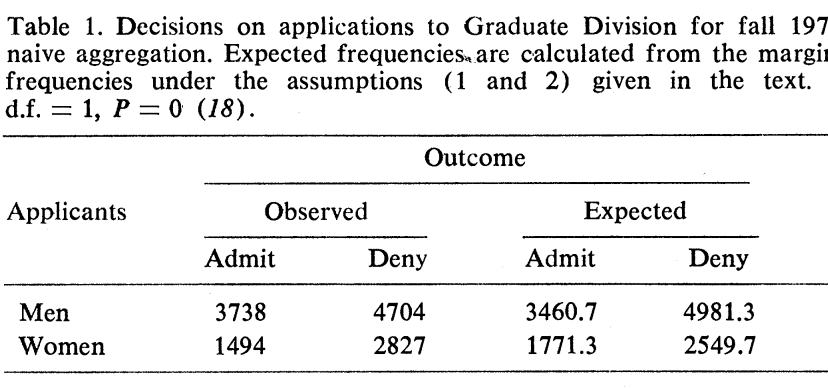

However some departments are specified as `Other` which are not included in table 1 in Wachter et al's work. See below. Moreover, there seems to be differences between my calculation and Wachter's. The Admitted Males numbers are completely different. The Rejected Males numbers are the same and the Admitted and Rejected Females are almost the same. 

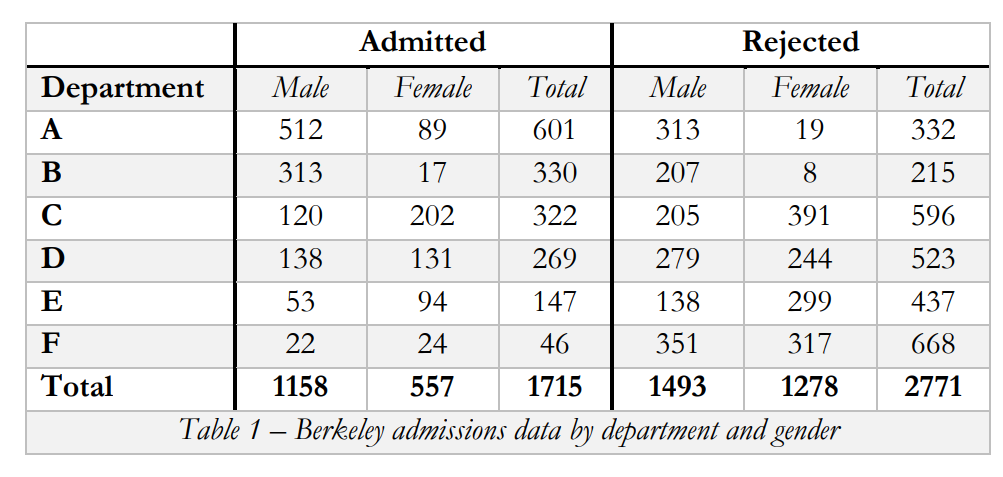

In [ ]:
df[df['Major'] != 'Other'][['Gender', 'Admission']].value_counts()

Gender  Admission
M       Accepted     1511
        Rejected     1493
F       Rejected     1278
        Accepted      557
dtype: int64

Admitted males should be 1511 and not 1158 as specified by Wachter, unless there is something I am missing...

In [ ]:
df[(df['Major'] != 'Other') & (df['Admission'] == 'Accepted')][['Gender', 'Major']].value_counts(sort=False)

In [ ]:
df[(df['Major'] != 'Other') & (df['Admission'] == 'Rejected')][['Gender', 'Major']].value_counts(sort=False)

In [ ]:
df.Year.value_counts(dropna=False)

In [ ]:
df.Gender.value_counts(dropna=False)

The Rejected Male values are exactly the same with the ones in Wachter's paper, thus the code below is consistent with Wachter's definition of CDD on page 56 of their work. 

In [ ]:
df = df[df['Major'] != 'Other']

In [ ]:
# Replicate Wachter et al.

R = 'Major'
prot = 'Gender'
target = 'Admission'

sizes = pd.DataFrame(df.groupby([R, target ,prot]).size(), columns = ['Number'])
sizes['Rate'] = round(sizes / sizes.groupby([target,R]).transform('sum'),2)
sizes = sizes.reset_index().pivot(index = R, columns = [target,prot], values = ['Rate','Number'])

sizes

Rate                        Number                       
Admission Accepted       Rejected       Accepted        Rejected       
Gender           F     M        F     M        F      M        F      M
Major                                                                  
A             0.10  0.90     0.06  0.94     89.0  825.0     19.0  313.0
B             0.05  0.95     0.04  0.96     17.0  353.0      8.0  207.0
C             0.63  0.37     0.66  0.34    201.0  120.0    392.0  205.0
D             0.49  0.51     0.47  0.53    131.0  138.0    244.0  279.0
E             0.64  0.36     0.68  0.32     94.0   53.0    299.0  138.0
F             0.53  0.47     0.47  0.53     25.0   22.0    316.0  351.0

In [ ]:
df[['Gender','Admission']].value_counts()

Gender  Admission
M       Accepted     1511
        Rejected     1493
F       Rejected     1278
        Accepted      557
dtype: int64

The results of Wachter have no weights. 

In [ ]:
np.round(sizes['Rate'].sum(axis=0) / 6, 2)

Admission  Gender
Accepted   F         0.41
           M         0.59
Rejected   F         0.40
           M         0.60
dtype: float64

In [ ]:
sizes['Rate'].values * df['Major'].value_counts().values.reshape((-1,1)) # correct

array([[ 124.6 , 1121.4 ,   74.76, 1171.24],
       [  45.9 ,  872.1 ,   36.72,  881.28],
       [ 498.96,  293.04,  522.72,  269.28],
       [ 349.86,  364.14,  335.58,  378.42],
       [ 374.4 ,  210.6 ,  397.8 ,  187.2 ],
       [ 309.52,  274.48,  274.48,  309.52]])

Which one should we use?

In [ ]:
np.sum(sizes['Rate'].values * df['Major'].value_counts(normalize=True).values.reshape((-1,1)),axis=0)

array([0.35198181, 0.64801819, 0.33933871, 0.66066129])

In [ ]:
df['Major'].value_counts()

A    1246
C     918
D     792
F     714
B     585
E     584
Name: Major, dtype: int64

In [ ]:
# Change Wachter et al. table order to make more intepretable

R = 'Major'
prot = 'Gender'
target = 'Admission'

sizes = pd.DataFrame(df.groupby([prot, target ,R]).size(), columns = ['Number'])
sizes['Rate'] = round(sizes / sizes.groupby([target,R]).transform('sum'),2)
sizes = sizes.reset_index().pivot(index = R, columns = [target,prot], values = ['Rate','Number'])

sizes

Rate                              Number                    \
Admission Accepted Rejected Accepted Rejected Accepted Rejected Accepted   
Gender           F        F        M        M        F        F        M   
Major                                                                      
A             0.10     0.06     0.90     0.94     89.0     19.0    825.0   
B             0.05     0.04     0.95     0.96     17.0      8.0    353.0   
C             0.63     0.66     0.37     0.34    201.0    392.0    120.0   
D             0.49     0.47     0.51     0.53    131.0    244.0    138.0   
E             0.64     0.68     0.36     0.32     94.0    299.0     53.0   
F             0.53     0.47     0.47     0.53     25.0    316.0     22.0   

                    
Admission Rejected  
Gender           M  
Major               
A            313.0  
B            207.0  
C            205.0  
D            279.0  
E            138.0  
F            351.0

In [ ]:
sizes

## Titanic

The titanic dataset is retrieved from [hbiostat](https://hbiostat.org/). For data collection, refer [here](https://hbiostat.org/data/repo/titanic5.html), the csv files are [here](https://hbiostat.org/data/) and [here](https://hbiostat.org/data/repo/titanic.html) - I decided to use the `titanic5.csv` following the [data colelction info](https://www.encyclopedia-titanica.org/). 

Feature engineering: extracted the title out of the names and replaced some values (see code below), dropped `Job` because there are only 59 entries and `occupation` can be used instead.

In [ ]:
df = pd.read_csv(path+'titanic5.csv', index_col=0)

# Extract titles
df['Name'] = df.Name.str.extract(r', (\w+)')

# Remove columns that repeat information or are not informative
df.drop(['Age_F_Code', 'Date_Death', 'DoB_Clean', 'URL', 'Occupation', 'Job', 'Age', 'Boat [Body]'], axis=1, inplace=True)

# Fill missing values
df.Age_F.fillna(25, inplace = True) # only two values missing here, both males and workers
#df.Occupation.fillna('Unknown', inplace = True)

df['Name'] = df.Name.replace({
    'Fr': 'Dr',
    'Sra': 'Mrs',
    'Mlle': 'Miss',
    'Col': 'Colonel',
    'Sr': 'Mr',
    'Rev': 'Priest',
    'Revd': 'Priest',
    'Doña': 'Miss',
    'Don': 'Mr',
    'Lady': 'Mrs',
    'Captain': 'Colonel',
    'Ms': 'Mrs',
    'Countess': 'Mrs'
})

# Place survived in the last column
survived = df.pop('Survived')
df['Survived'] = survived

# Fill missing Price values
df[(df['Ticket'] == '370160')] = df[(df['Ticket'] == '370160')].replace(' ', '£7 5s')
df['Price'] = df.Price.str.extract(r'£(\w+)')
df[df['Ticket'] == '19972']['Price'] = df[(df['Sex'] == 'male') & (df['Class'] == 1) & (df['Joined'] == 'Cherbourg')]['Price'].dropna().astype('int').median()
df.Price.fillna(0, inplace = True)
df['Price'] = df['Price'].astype('float64')
df['Price'] = df['Price'].astype('float64')

# There are 900 different tickets for 1300 passengers. This categorical feature does not have much predictive power and Occupation serves as a proxy. dropping it. 
df.drop(['Ticket'], axis=1, inplace=True)

R: (i) , (ii) , (iii) combine . To-do : Check and report correlation between R and protected feature!

In [ ]:
df.head()

,Name,Sex,Class,Joined,Price,Age_F,sibsp,parch,Survived
Name_ID,,,,,,,,,
28,Miss,female,1,Southampton,211.0,29.0,0,0,1
35,Master,male,1,Southampton,151.0,1.0,1,2,1
36,Miss,female,1,Southampton,151.0,2.0,1,2,0
37,Mr,male,1,Southampton,151.0,30.0,1,2,0
38,Mrs,female,1,Southampton,151.0,25.0,1,2,0


In [ ]:
df['Survived'] = np.where(df['Survived'] == 1, 'survived', 'not survived')
df.to_csv(path+'titanic.csv')

In [ ]:
pd.read_csv(path+'titanic.csv', index_col=0)

In [ ]:
dataset = 'Titanic'
target = "Survived" # or two_year_recid (the ground truth), compas_guess are COMPAS's predictions
prot = 'Sex' # 
pos_label = 1
priv_group = 'female'
unpriv_group = 'male'
neg_label = 0
#numeric = [False, False, True, False, False, True, True, True, True] # to fix
#dtype_dic = {col:'object' if not dtype else 'int64' for dtype, col in zip(numeric, df.columns)}
#df = df.astype(dtype_dic)
class_order = [0,1]

In [ ]:
df.head()

Dummy code for aif360 - not sure if this is needed. 

In [ ]:
l = list(df.columns)
l.remove(target)
X, y = df[l], df[target]

X_enc = copy.deepcopy(X)

#scaler = MinMaxScaler()
#X_enc[X_enc.select_dtypes(exclude='object').columns] = scaler.fit_transform(X_enc.select_dtypes(exclude='object'))

# dummy variables
dummies = pd.get_dummies(X_enc.select_dtypes(include='object'), drop_first=True)
X_enc.drop(X_enc.select_dtypes(include='object').columns,axis=1, inplace=True)
X_enc[dummies.columns] = dummies.values

In [ ]:
def age_cut(x):
  if x >= 70:
      return '>=70'
  else:
      return x

In [ ]:
df['Age (decade)'] = df['Age_F'].apply(lambda x: x//10*10)

"Sex_male"? as prot instead of 'sex'. How do we make meaningful and legal bins?

In [ ]:
df['Price'].apply(lambda x: x//50*50).value_counts()

In [ ]:
df['Price']

In [ ]:
X_enc.describe()

In [ ]:
X_enc

In [ ]:
y.value_counts(normalize='all')

In [ ]:
# baseline

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.5, random_state=0)

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

What is the condition here? What about age? Binary: child-adult, old-young? What is the practice in the literature.

In [ ]:
#CDD (Wachter et al. 2021) - we need to specify the other attributes R - here I will condition on the race or sex
R = 'Class'

sizes = pd.DataFrame(df.groupby([R,target,prot]).size(), columns = ['Number'])
sizes['Rate'] = round(sizes / sizes.groupby([target,R]).transform('sum'),2)
sizes = sizes.reset_index().pivot(index = R, columns = [target,prot], values = ['Rate','Number'])

sizes

In [ ]:
y = df[target]
y.index = df[prot]

print(prot)
compute_kl_div(y, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True)

In [ ]:
results, metrics_results, _ = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order)
results

In [ ]:
results, metrics_results, _ = group_metrics(df, target, prot, neg_label, pos_label, priv_group, metrics_results, class_order, remove_prot_from_class=False)
results

## Adult & CDD

In [ ]:
# adult
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
           'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv(path+'adult.data', names = columns, index_col=None)
df.drop(['education-num', 'native-country'], axis=1, inplace=True) # removed 'native-country' to reduce dimensionality since I will dummy-code

df_obj = df.select_dtypes(include='object')
df[df_obj.columns] = df.select_dtypes(include='object').apply(lambda x: x.str.strip(' '))
target = 'income'
prot = 'sex'

dataset = 'Adult'
prot = 'sex' # 
pos_label = '>50K'
priv_group = 'Female' # White
unpriv_group = 'Male' # Black
neg_label = '<=50K'
#numeric = [False, False, True, False, False, True, True, True, True] # to fix
#dtype_dic = {col:'object' if not dtype else 'int64' for dtype, col in zip(numeric, df.columns)}
#df = df.astype(dtype_dic)
class_order = ['<=50K','>50K']

In [ ]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'income'],
      dtype='object')

#### CDD

`R`: (i) education, (ii) occupation, (iii) combine education with education. To-do : Check and report correlation between R and protected feature! 

In [ ]:
cdd_sizes = {}
Rs = ['education', 'occupation']
Y = 'income'
prots = ['sex', 'race']

for prot in prots:
  cdd_sizes[prot] = {}
  for R in Rs:
    
    cdd_data = pd.DataFrame(np.array([df[Y].values, df[R], df[prot]]).T, columns = ['Label', R, prot])

    sizes = pd.DataFrame(cdd_data.groupby([prot,'Label',R]).size(), columns = ['Number '+Y])
    sizes['Rate '+Y] = round(sizes / sizes.groupby(['Label',R]).transform('sum'),2)
    cdd_sizes[prot][R] = pd.DataFrame(sizes)

In [ ]:
# occupation has 6% missing values. I think that is acceptable
df.occupation.value_counts(normalize ='all', dropna=False).loc['?']

0.056601455729246644

In [ ]:
cdd_sizes['sex']['occupation'].columns

Index(['Number income', 'Rate income'], dtype='object')

I will compare the protected features first and then, maybe the Rs.

In [ ]:
cdd = {}
for R in Rs:
  cdd[R] = {}
  for prot in prots:
    pivot = cdd_sizes[prot][R].reset_index().pivot(columns = ['Label', prot], index = R, values = ['Rate income'])
    cdd_row = []
    for pair in pivot.columns:
      group_label = pd.DataFrame(pivot[pair[0]][pair[1]][pair[2]])
      
      weights = pd.DataFrame(np.unique(df[R], return_counts=True)).T
      weights.columns = [R, 'Weights']
      weights.set_index(R, inplace = True)

      group_label['Weights'] = weights['Weights']
      group_label.fillna(0, inplace=True)

      cdd_agg = round(sum(group_label[pair[2]] * group_label['Weights']) / len(df[R]),2)
      cdd_row.append(cdd_agg)

      #print(cdd_agg, end = ' | ')
      #print(pair[1:])
    pivot.loc['All'] = np.array(cdd_row)
    cdd[R][prot] = pivot

Occupation and education as criteria are both very similar. Education is chosen since it precedes occupation and is also prerequisite for different occupation types. 

In [ ]:
all_cdd['adult'] = {}

compare = pd.DataFrame(cdd[Rs[0]]['sex'].iloc[-1,:]).T
compare.index = [Rs[0]]

all_cdd['adult']['sex'] = compare
compare

Rate income                   
Label           <=50K   >50K <=50K  >50K
sex            Female Female  Male  Male
education        0.39   0.14  0.61  0.86

In [ ]:
all_cdd['adult'] = {}

compare = pd.DataFrame(cdd[Rs[0]]['race'].iloc[-1,:]).T
compare.index = [Rs[0]]

all_cdd['adult']['race'] = compare
compare

Rate income                                        \
Label                  <=50K               >50K              <=50K   
race      Amer-Indian-Eskimo Amer-Indian-Eskimo Asian-Pac-Islander   
education               0.01                0.0               0.03   

                                                                  
Label                   >50K <=50K  >50K <=50K  >50K <=50K  >50K  
race      Asian-Pac-Islander Black Black Other Other White White  
education               0.03   0.1  0.06  0.01   0.0  0.84   0.9

Now we need to test statistical correlation / association between the explainable feature and the classification outcome. In Adult, the outcome is binary and occupation is categorical. We follow [Haldun Akoglu's approach](https://www.sciencedirect.com/science/article/pii/S2452247318302164?via%3Dihub) regarding the association strength.

In [ ]:
Ys = [Y]

from scipy.stats import chi2_contingency

for Y in Ys:
  print('Compute strength of association between', Y, 'with', Rs[0])
  statistic, pvalue, dof, expected_freq  = chi2_contingency(pd.crosstab(df[Y], df[Rs[0]]))
  significance = 'significant 'if pvalue < 0.05 else 'non-significant'
  print('chi2 statistic:', np.round(statistic,2), 'with a p-value of', np.round(pvalue,3), 'means that the association is',significance, 'dof:', dof)

  X2  = chi2_contingency(pd.crosstab(df[Y], df[Rs[0]]))[0]
  N = len(df)
  minimum_dimension = min(df.shape)-1
  result = np.sqrt((X2/N) / minimum_dimension)
  association_strength = 'weak' if result < 0.10 else 'moderate' if ((result >= 0.10) & (result < 0.15)) else 'strong' 
  print("Cramer's V:", np.round(result,2), 'means that the association is', association_strength)
  print(' ')

Compute strength of association between income with education
chi2 statistic: 4429.65 with a p-value of 0.0 means that the association is significant  dof: 15
Cramer's V: 0.11 means that the association is moderate
 


#### Other metrics

In [ ]:
# to be added lol

## Bank marketing

Maybe - include? See: Adaptive Sensitive Reweighting to Mitigate Bias in Fairness-aware Classification

## Metaclassifier

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa/metaclassifier_aif360/')

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
#from aif360.metrics import BinaryLabelDatasetMetric
#from aif360.metrics import ClassificationMetric

from meta_fair_classifier import MetaFairClassifier

np.random.seed(12345)

#from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
#dataset_orig = load_preproc_data_adult()

In [ ]:
import adult_dataset, compas_dataset, titanic_dataset
import binary_label_dataset, binary_label_dataset_metric
import classification_metric
import data_preproc_functions
import dataset, dataset_metric, metric
import standard_dataset, structured_dataset

from binary_label_dataset_metric import BinaryLabelDatasetMetric
from classification_metric import ClassificationMetric
from data_preproc_functions import load_preproc_data_compas, load_preproc_data_adult, load_preproc_data_titanic

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


### Run meta classifier 

The two bias metrics, that are used as a constraint for the meta-classifier, are presented below under parameter `type`.

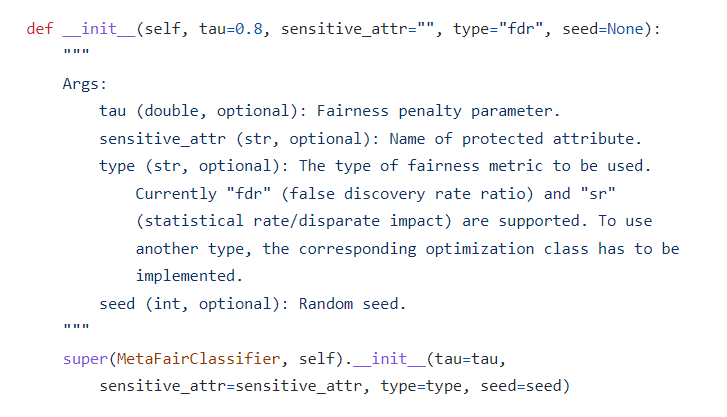

In [ ]:
def data_for_cdd(dataset, Rs, include_predictions = False, predictions = None):
  df = dataset.convert_to_dataframe()[0]

  # undummify R in test set
  col_list = list(df.columns)
  undumify = df[[col for col in col_list if Rs[0].lower() in col.lower()]]

  undumify.index.name = 'ID'
  undumify = undumify[undumify==1].stack().reset_index().drop(0, axis=1)
  undumify.set_index('ID',inplace=True)

  undumify[dataset.label_names[0]] = df[dataset.label_names[0]].replace(dataset.metadata['label_maps'][0])
  #undumify[dataset_orig_test.label_names[0]] = dataset_orig_test.convert_to_dataframe()[0][dataset_orig_test.label_names[0]]

  if dataset.metadata['protected_attribute_maps'][0][0].lower() in ['male','female']:
    undumify['sex'] = df['sex'].replace(dataset.metadata['protected_attribute_maps'][0])

  if dataset.metadata['protected_attribute_maps'][1][0].lower() in ['white', 'caucasian', 'black', 'non-white', 'not caucasian']:
    undumify['race'] = df['race'].replace(dataset.metadata['protected_attribute_maps'][1])

  undumify.rename(columns={'level_1':Rs[0]}, inplace=True)

  if include_predictions:
    undumify[dataset.label_names[0]] = pd.DataFrame(predictions.labels,index=df.index).replace(dataset.metadata['label_maps'][0])

  return undumify

In [ ]:
def cdd(data, dataset, prots, Rs):

  Ys = dataset.label_names
  prots = prots #dataset.protected_attribute_names

  cdd_sizes = {}

  # Make Table 1 and  in Wachter
  for Y in Ys:
    cdd_sizes[Y] = {}
    for prot in prots:
      cdd_sizes[Y][prot] = {}
      for R in Rs:
        cdd_data = pd.DataFrame(np.array([data[Y].values, data[R], data[prot]]).T, columns = ['Label', R, prot])

        sizes = pd.DataFrame(cdd_data.groupby([prot,'Label',R]).size(), columns = ['Number '+Y])
        sizes['Rate '+Y] = round(sizes / sizes.groupby(['Label',R]).transform('sum'),2)
        cdd_sizes[Y][prot][R] = pd.DataFrame(sizes)
  
  # Aggregate as in Table 3 of Wachter
  cdd = {}
  for Y in Ys: # In case we have multiple target
    cdd[Y] = {}
    for R in Rs: # For multiple conditions
      cdd[Y][R] = {}
      for prot in prots: # For multiple protected features

        pivot = cdd_sizes[Y][prot][R].reset_index().pivot(columns = ['Label', prot], index = R, values = ['Rate '+Y])
        cdd_row = []
        for pair in pivot.columns:
          group_label = pd.DataFrame(pivot[pair[0]][pair[1]][pair[2]])
          
          weights = pd.DataFrame(np.unique(data[R], return_counts=True)).T
          weights.columns = [R, 'Weights']
          weights.set_index(R, inplace = True)

          group_label['Weights'] = weights['Weights']
          group_label.fillna(0, inplace=True)

          #print(pair, sum(group_label['Weights']), len(data[R]))

          cdd_agg = round(sum(group_label[pair[2]] * group_label['Weights']) / len(data[R]),2)
          cdd_row.append(cdd_agg)

        pivot.loc['All'] = np.array(cdd_row)
        cdd[Y][R][prot] = pivot
  
  cdd_agg_tables = {}
  final_ratios = {}

  for prot in prots:
    cdd_ratio = pd.DataFrame(cdd[dataset.label_names[0]][Rs[0]][prot].iloc[-1,:]).T
    cdd_agg_tables[prot] = cdd_ratio

    try:
      unfav_unpriv = cdd_ratio[('Rate '+dataset.label_names[0], 
            unprivileged_metadata_label['unfavorable'], 
            unprivileged_metadata_prot['unprivileged'][prot])][0]
    except KeyError:
      unfav_unpriv = 0

    try:        
      fav_unpriv = cdd_ratio[('Rate '+dataset.label_names[0], 
              unprivileged_metadata_label['favorable'], 
              unprivileged_metadata_prot['unprivileged'][prot])][0]
    except KeyError:
      fav_unpriv = 0

    #print('unpriviledged', prot, unprivileged_metadata_prot['unprivileged'][prot], min(unfav_unpriv,fav_unpriv) / max(unfav_unpriv,fav_unpriv), end=', ')

    try:
      unfav_priv = cdd_ratio[('Rate '+dataset.label_names[0], 
            unprivileged_metadata_label['unfavorable'], 
            unprivileged_metadata_prot['privileged'][prot])][0] 
    except KeyError:
      unfav_priv = 0

    try:     
     fav_priv = cdd_ratio[('Rate '+dataset.label_names[0], 
              unprivileged_metadata_label['favorable'], 
              unprivileged_metadata_prot['privileged'][prot])][0]
    except KeyError:
      fav_priv = 0

    final_ratios[prot] = pd.DataFrame(data={unprivileged_metadata_prot['unprivileged'][prot]:min(unfav_unpriv,fav_unpriv) / max(unfav_unpriv,fav_unpriv),
                                            unprivileged_metadata_prot['privileged'][prot]: min(unfav_priv,fav_priv) / max(unfav_priv,fav_priv)}, index=[prot])
  
  #print('priviledged', prot, unprivileged_metadata_prot['privileged'][prot], min(unfav_priv,fav_priv) / max(unfav_priv,fav_priv))

  return final_ratios, cdd_agg_tables, cdd, cdd_sizes

In [ ]:
def run_metaclassifier_crossval(folds, dataset_orig, Rs, metadata, mitigation_types = ['sr', 'fdr']):
  hp_results = {}
  prot_attr_map = {}

  for s_attr, priv, unpriv in zip(dataset_orig.protected_attribute_names, dataset_orig.privileged_protected_attributes, dataset_orig.unprivileged_protected_attributes):
    prot_attr_map[s_attr] = {}

    prot_attr_map[s_attr]['Privileged'] = priv
    prot_attr_map[s_attr]['Unprivileged'] = unpriv

  for mitigation_type in mitigation_types:
    print(' ')
    print('---------------')
    print('mitigation type', mitigation_type)
    hp_results[mitigation_type] = {}

    for s_attr in dataset_orig.protected_attribute_names:
      print(' ')
      print('protected feature', s_attr)
      print('Folds:', end = '')
      privileged_groups = [{s_attr: prot_attr_map[s_attr]['Privileged'][0]}]
      unprivileged_groups = [{s_attr: prot_attr_map[s_attr]['Unprivileged'][0]}]

      hp_results[mitigation_type][s_attr] = {}

      for fold in range(0,folds):
        print(str(fold)+' ', end = '')
        hp_results[mitigation_type][s_attr]['Fold'+str(fold)] = {}

        dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed = 100*fold)

        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier()
        clf.fit(dataset_orig_train.convert_to_dataframe()[0].iloc[:,:-1], dataset_orig_train.convert_to_dataframe()[0].iloc[:,-1])
        acc_base_score = clf.score(dataset_orig_test.convert_to_dataframe()[0].iloc[:,:-1], dataset_orig_test.convert_to_dataframe()[0].iloc[:,-1])

        # scaling is not necessary here since everything is between 0-1 already. they do it in the jupyter notebook so...
        min_max_scaler = MaxAbsScaler()
        dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
        dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)

        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)

        metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)

        # demographic parity
        dpratio_train = min(metric_orig_train.disparate_impact(), 1/metric_orig_train.disparate_impact()) # pretrain
        dpratio_test = min(metric_orig_test.disparate_impact(), 1/metric_orig_test.disparate_impact()) # pretrain

        # CDD

        cdd_df = data_for_cdd(dataset_orig_train, Rs)
        cdd_ratios_train, cdd_agg_train, _, _ = cdd(cdd_df, dataset_orig_train, [s_attr], Rs)

        cdd_df = data_for_cdd(dataset_orig_test, Rs)
        cdd_ratios_test, cdd_agg_test, all, _ = cdd(cdd_df, dataset_orig_test, [s_attr], Rs)

        cdd_unpriv_train = cdd_ratios_train[s_attr][metadata['unprivileged_metadata_prot']['unprivileged'][s_attr]].values[0]
        cdd_priv_train = cdd_ratios_train[s_attr][metadata['unprivileged_metadata_prot']['privileged'][s_attr]].values[0]

        cdd_unpriv_test = cdd_ratios_test[s_attr][metadata['unprivileged_metadata_prot']['unprivileged'][s_attr]].values[0]
        cdd_priv_test = cdd_ratios_test[s_attr][metadata['unprivileged_metadata_prot']['privileged'][s_attr]].values[0]

        for tau in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)] = {}

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['RandomForrest accuracy'] = acc_base_score
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['DP GT train'] = dpratio_train
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['DP GT test'] = dpratio_test

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT train unpriv'] = cdd_unpriv_train
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT train priv'] = cdd_priv_train         
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT test unpriv'] = cdd_unpriv_test
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT test priv'] = cdd_priv_test

          biased_model = MetaFairClassifier(tau=tau, sensitive_attr=s_attr, type=mitigation_type).fit(dataset_orig_train)
          dataset_bias_test = biased_model.predict(dataset_orig_test)

          # compute CDD on predictions with tau0
          cdd_df = data_for_cdd(dataset_bias_test, Rs, include_predictions = True, predictions = dataset_bias_test)
          cdd_ratios_preds, cdd_agg_preds, all, sizes = cdd(cdd_df, dataset_bias_test, [s_attr], Rs)
          cdd_unpriv_preds = cdd_ratios_preds[s_attr][metadata['unprivileged_metadata_prot']['unprivileged'][s_attr]].values[0]
          cdd_priv_preds = cdd_ratios_preds[s_attr][metadata['unprivileged_metadata_prot']['privileged'][s_attr]].values[0]

          classified_metric_bias_test = ClassificationMetric(dataset_orig_test, dataset_bias_test,
                                                        unprivileged_groups=unprivileged_groups,
                                                        privileged_groups=privileged_groups)
          
          TPR = classified_metric_bias_test.true_positive_rate()
          TNR = classified_metric_bias_test.true_negative_rate()
          bal_acc_bias_test = 0.5*(TPR+TNR)

          dpratio = min(classified_metric_bias_test.disparate_impact(), 1/classified_metric_bias_test.disparate_impact())

          fdr = classified_metric_bias_test.false_discovery_rate_ratio()
          fdr = min(fdr, 1/fdr)

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['Metaclass. accuracy'] = classified_metric_bias_test.accuracy()
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['FDR'] = fdr
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['DP'] = dpratio
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD preds unpriv'] = cdd_unpriv_preds
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD preds priv'] = cdd_priv_preds

          
  return hp_results

In [ ]:
case_name = 'adult' # compas_twoyear, adult
dataset_orig = load_preproc_data_adult() # load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_titanic
print(dataset_orig.label_names, dataset_orig.protected_attribute_names)

['Income Binary'] ['sex', 'race']


In [ ]:
# making my own metadata --------------------------------------------------
metadata_adult = {
    'unprivileged_metadata_prot': {
        'unprivileged':{'sex':'Female','race':'Non-white'},
        'privileged':{'sex':'Male','race':'White'}
            },
            'unprivileged_metadata_label': {
                'unfavorable':'<=50K',
                'favorable':'>50K'}
            }

metadata_compas = {
    'unprivileged_metadata_prot': {
        'unprivileged':{'sex':'Male','race':'Not Caucasian'},
        'privileged':{'sex':'Female','race':'Caucasian'}
            },
            'unprivileged_metadata_label': {
                'unfavorable':'Did recid.',
                'favorable':'No recid.'}
                }

my_metadata = {
    'compas_guess': metadata_compas,
    'compas_twoyear': metadata_compas,
    'adult': metadata_adult
}

unprivileged_metadata_prot, unprivileged_metadata_label = my_metadata[case_name]['unprivileged_metadata_prot'], my_metadata[case_name]['unprivileged_metadata_label']

Rs = {
    'compas_guess': ['priors'],
    'compas_twoyear': ['priors'],
    'adult': ['education']
}

In [ ]:
results = run_metaclassifier_crossval(10, dataset_orig, Rs[case_name], my_metadata[case_name]) # sr also needs to be hyperoptimized

import pickle 

with open(path+case_name+'_cdd_10fold_hp_optimization_.pkl', 'wb') as f:
    pickle.dump(results, f)

 
---------------
mitigation type sr
 
protected feature sex
Folds:0 1 2 3 4 5 6 7 8 9  
protected feature race
Folds:0 1 2 3 4 5 6 7 8 9  
---------------
mitigation type fdr
 
protected feature sex
Folds:0 1 2 3 4 5 6 7 8 9  
protected feature race
Folds:0 1 2 3 4 5 6 7 8 9 

### Create final results table

In [ ]:
import glob
import re
import pickle

Collecting all the experiments form google drive and saving them in the `cases` dictionary.

In [ ]:
cases = {}

for file_name in glob.glob(path+'*.pkl'):
  try: 
    name = re.findall('Datasets\/(.*)_cdd_10fold_hp_optimization_.pkl', file_name)[0]
  except IndexError:
    continue
  print(file_name)
  f = open(file_name, 'rb')
  loaded_dict = pickle.load(f)
  cases[name] = loaded_dict

/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa/Datasets/compas_guess_cdd_10fold_hp_optimization_.pkl
/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa/Datasets/compas_twoyear_cdd_10fold_hp_optimization_.pkl
/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa/Datasets/adult_cdd_10fold_hp_optimization_.pkl


In [ ]:
cases.keys()

dict_keys(['compas_guess', 'compas_twoyear'])

First we gotta take the average between the folds for each sensitive attribute, tau value and constraint option. To do that I need to rearrange my data because I did not loop through them properly. I maybe have to change the loop in the `run_metaclassifier_crossval` and do `tau` first and then `fold`. It might be easier to take the average among the folds.

In [ ]:
all_metrics = {}
for c in cases.keys():
  all_metrics[c] = {}
  for constraint in cases[c].keys():
    all_metrics[c][constraint] = {}
    for s_attr in cases[c][constraint].keys():
      all_metrics[c][constraint][s_attr] = {}
      for metric in pd.DataFrame(cases[c][constraint][s_attr]['Fold1']).index:
        all_metrics[c][constraint][s_attr][metric] = pd.DataFrame(index=cases[c][constraint][s_attr].keys(), columns=cases[c][constraint][s_attr]['Fold1'].keys())
        for fold in cases[c][constraint][s_attr].keys():
          #print('')
          #print(fold, end = ' - ')
          for tau in cases[c][constraint][s_attr][fold].keys():
            #print(tau, ':_', cases['compas_guess']['sr']['sex'][fold][tau]['Metaclass. accuracy'], end = ' ')
            all_metrics[c][constraint][s_attr][metric].loc[fold, tau] = cases[c][constraint][s_attr][fold][tau][metric]

After rearranging my data, I can now take the mean of all folds for each tau value. Then, I have to choose the tau per case, constraint and protected feature. After that I will create the final table. 

#### Compas

In [ ]:
cases.keys()

dict_keys(['compas_guess', 'compas_twoyear', 'adult'])

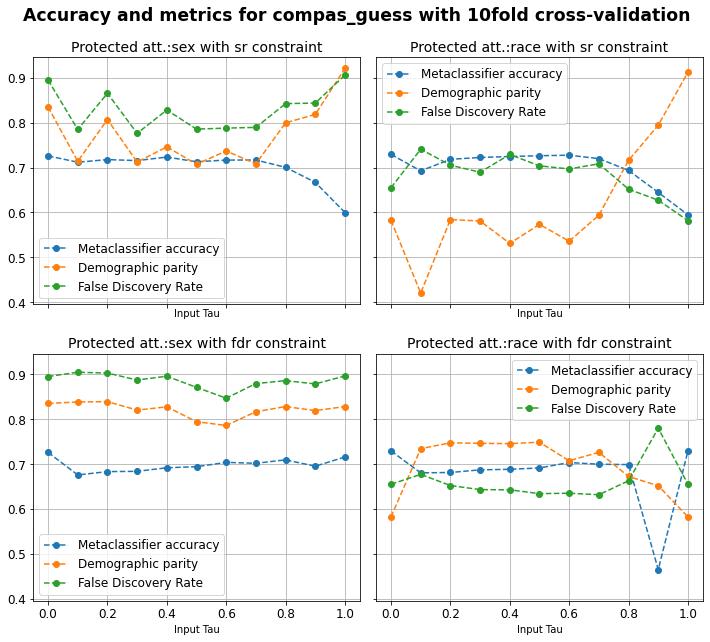

In [ ]:
case_study = 'compas_guess'
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.05)

means = {}

axs = axs.ravel()

import itertools
tickers = [combo for combo in itertools.product(all_metrics[case_study].keys(), all_metrics[case_study]['sr'].keys())]

for ticker, i in zip(tickers, range(len(tickers))):

  means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr']['sex']['FDR'].columns,
                             columns = all_metrics[case_study]['sr']['sex'].keys())
  
  for metric in all_metrics[case_study]['sr']['sex'].keys():
    #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
    means_per_tau[metric] = all_metrics[case_study][ticker[0]][ticker[1]][metric].mean(axis=0)

  means[ticker] = means_per_tau

  accuracies, statistical_rates, fdr = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values
  all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]

  import matplotlib.pyplot as plt

  axs[i].plot(all_tau, accuracies, label = 'Metaclassifier accuracy', linestyle="--",marker="o")
  axs[i].plot(all_tau, statistical_rates, label = 'Demographic parity', linestyle="--",marker="o")
  axs[i].plot(all_tau, fdr, label = 'False Discovery Rate', linestyle="--",marker="o")
  axs[i].set_xlabel('Input Tau')
  axs[i].tick_params(labelsize = 'large')
  axs[i].set_title('Protected att.:'+ticker[1]+' with '+ticker[0]+' constraint', fontsize=14)

  axs[i].legend(prop={'size':12})
  axs[i].grid()

folds = len(cases[case_study]['sr']['sex'].keys())
fig.suptitle('Accuracy and metrics for '+case_study+' with '+str(folds)+'fold cross-validation', y=0.95, fontsize='xx-large', fontweight='bold')
plt.savefig(path+"Figures/"+case_study+".pdf", format="pdf", bbox_inches="tight")
plt.show()

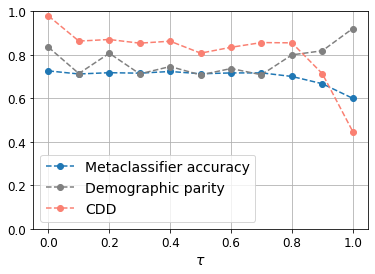

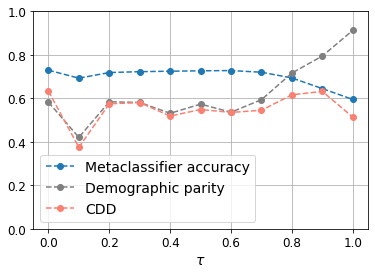

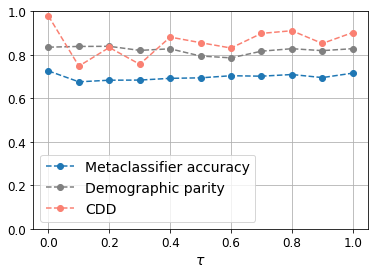

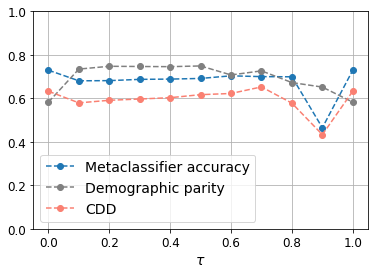

In [ ]:
case_study = 'compas_guess'
means = {}

axs = axs.ravel()

import itertools
tickers = [combo for combo in itertools.product(all_metrics[case_study].keys(), all_metrics[case_study]['sr'].keys())]

for ticker, i in zip(tickers, range(len(tickers))):

  means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr']['sex']['FDR'].columns,
                             columns = all_metrics[case_study]['sr']['sex'].keys())
  
  for metric in all_metrics[case_study]['sr']['sex'].keys():
    #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
    means_per_tau[metric] = all_metrics[case_study][ticker[0]][ticker[1]][metric].mean(axis=0)

  means[ticker] = means_per_tau

  accuracies, statistical_rates, fdr, CDD = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values, means_per_tau['CDD preds unpriv'] 
  all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]

  import matplotlib.pyplot as plt

  plt.plot(all_tau, accuracies, label = 'Metaclassifier accuracy', linestyle="--",marker="o")
  plt.plot(all_tau, statistical_rates, label = 'Demographic parity', linestyle="--",marker="o", c='grey')
  #plt.plot(all_tau, fdr, label = 'False Discovery Rate', linestyle="--",marker="o", c='green')
  plt.plot(all_tau, CDD, label = 'CDD', linestyle="--",marker="o", c='salmon')
  plt.xlabel(r'$\tau$', size=14)
  plt.tick_params(labelsize = 'large',which='major')
  plt.ylim(bottom=0,top=1)
  #plt.title('Protected att.:'+ticker[1]+' with '+ticker[0]+' constraint', fontsize=14)

  plt.legend(prop={'size':14})
  plt.grid(visible=True)
  
  plt.savefig(path+"Figures/"+case_study+str(ticker[0])+str(ticker[1])+".pdf", format="pdf", bbox_inches="tight")
  #plt.suptitle('Accuracy and metrics for '+case_study+' with '+str(folds)+'fold cross-validation', y=0.95, fontsize='xx-large', fontweight='bold')
  plt.show()

In [ ]:
two_year_recid.value_counts(normalize=True).round(2)

0    0.55
1    0.45
Name: two_year_recid, dtype: float64

Case `two_year_recid`: Here we train a classifier using the actual recidivism labels collected by Propublica as target label. 55% of the offenders did not recidivate and, in machine learning problems, this number is usually considered a baseline for the clasifier performance. To clarify, a very bad classifier which assigns the same label ('No Recid.') to all offenders would be at least 55% correct. Therefore, a better classifier should at least have a higher accuracy than this very simple threshold. The metaclassifier reaches a 66%-67% accuracy given the data which is not much better either. In other words, the automated decision making process might is not very efficient given the combination of data and given classifiers. Nevertheless, for the sake of the experiment, we move on with our analysis.

- Choose $τ$: 
  - Under `sr` constraint for `sex`, if $τ = 0.9$, DP is 82% with a 63% accuracy. However, at $τ = 0.0$ DP is 79%, which is quite similar, and accuracy is 67%. This means that the algorithm can only increase fairness by 3% while still preserving some decision making power. 
  - Under `sr` constraint for `race`. If $τ = 0.9$, DP is 80% with a 63% accuracy. At $τ = 0.0$ DP is 71%, with a 67% accuracy.
  - Under `fdr` constraint for `sex`, both accuracy and fairness $τ$ remain at roughly the same as we vary $τ$. Therefore, we randomly chose $τ = 0.8$ for our comparison.
  - Under `fdr` constraint for `sex`, both accuracy and fairness $τ$ remain at roughly the same as we vary $τ$, i.e. no bias mitigation is needed. Therefore, we randomly chose $τ = 0.7$ for our comparison.

In [ ]:
compas_guess.value_counts(normalize=True).round(2)

0    0.54
1    0.46
Name: compas_guess, dtype: float64

Case `compas_guess`: Here we train a classifier using Northpoint's recidivism risk as target label. 54% of the offenders did not recidivate which serves as our baseline. The metaclassifier reaches a 72% accuracy which is slighty better than the 67% when label is `two_recid_recid`. 

- Choose $τ$: 
  - Under `sr` constraint for `sex`, if $τ = 0.9$, DP is 85% with a 67% accuracy. However, at $τ = 0.0$ DP is 82%, which is quite similar, and accuracy is 72%. This means that the algorithm can only increase fairness by 3% while the decision making power gradually deteriorating. 
  - Under `sr` constraint for `race` . If $τ = 0.8$, DP is 70% with a 70% accuracy. At $τ = 0.0$ DP is 58%, with a 72% accuracy. The metaclassifier is cleary increasing fairness while preerving its classification power.
  - Under `fdr` constraint for `sex`, both accuracy and fairness $τ$ remain at roughly the same as we vary $τ$. Therefore, we randomly chose $τ = 0.8$ for our comparison. 
  - Under `fdr` constraint for `race`, we chose $τ = 0.8$ since accuracy is 69%, FDR roughly increases to 65% from 62% when $τ = 0$. At $τ = 0.8$ DP also increases to 70% from 59%.

In [ ]:
cols = ['Dataset', 'Constraint', 'Protected att.', 'Best Classifier',  'Best accuracy', 'DP GT train',
        'DP GT test', 'CDD GT train unpriv', 'CDD GT train priv', 'CDD GT test unpriv', 'CDD GT test priv', 
        'Metaclass. accuracy', 'FDR AT', 'DP AT', 'CDD AT unpriv', 'CDD AT priv']
final_results = pd.DataFrame(columns=cols)

cols_0 = ['Dataset', 'Constraint', 'Protected att.', 'Best Classifier',  'Best accuracy', 'DP GT train',
        'DP GT test', 'CDD GT train unpriv', 'CDD GT train priv', 'CDD GT test unpriv', 'CDD GT test priv', 
        'Metaclass. accuracy Tau0', 'FDR AT Tau0', 'DP AT Tau0', 'CDD AT unpriv Tau0', 'CDD AT priv Tau0']
final_results_tau0 = pd.DataFrame(columns=cols_0)

In [ ]:
compas_twoyear_tau = [0.9, 0.9, 0.8, 0.7]
compas_guess_tau = [0.8, 0.9, 0.8, 0.8]

taus = []
for key, tau in zip(means.keys(), compas_guess_tau): # or compas_guess_tau
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols
  to_append['Chosen tau'] = str(tau)
  final_results = final_results.append(to_append)

for key, tau in zip(means.keys(), [0.0, 0.0, 0.0, 0.0]):
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols_0
  final_results_tau0 = final_results_tau0.append(to_append)

add_tau0 = final_results_tau0[final_results_tau0.columns[11:]].columns
final_results[add_tau0] = final_results_tau0[add_tau0].values

In [ ]:
79-58

21

In [ ]:
final_results[final_results['Constraint'] == 'sr'].columns

Index(['Dataset', 'Constraint', 'Protected att.', 'Best Classifier',
       'Best accuracy', 'DP GT train', 'DP GT test', 'CDD GT train unpriv',
       'CDD GT train priv', 'CDD GT test unpriv', 'CDD GT test priv',
       'Metaclass. accuracy', 'FDR AT', 'DP AT', 'CDD AT unpriv',
       'CDD AT priv', 'Chosen tau', 'Metaclass. accuracy Tau0', 'FDR AT Tau0',
       'DP AT Tau0', 'CDD AT unpriv Tau0', 'CDD AT priv Tau0'],
      dtype='object')

In [ ]:
final_results[final_results['Constraint'] == 'sr'][['Dataset','Protected att.', 'Metaclass. accuracy', 'DP AT', 'CDD AT unpriv','Chosen tau',
                                                    'Metaclass. accuracy Tau0', 'DP AT Tau0', 'DP GT test', 'CDD GT test unpriv']]

,Dataset,Protected att.,Metaclass. accuracy,DP AT,CDD AT unpriv,Chosen tau,Metaclass. accuracy Tau0,DP AT Tau0,DP GT test,CDD GT test unpriv
0,compas_guess,sex,0.7,0.8,0.86,0.8,0.73,0.84,0.93,0.97
0,compas_guess,race,0.64,0.79,0.63,0.9,0.73,0.58,0.64,0.73


#### Adult

Take the mean of all folds. 

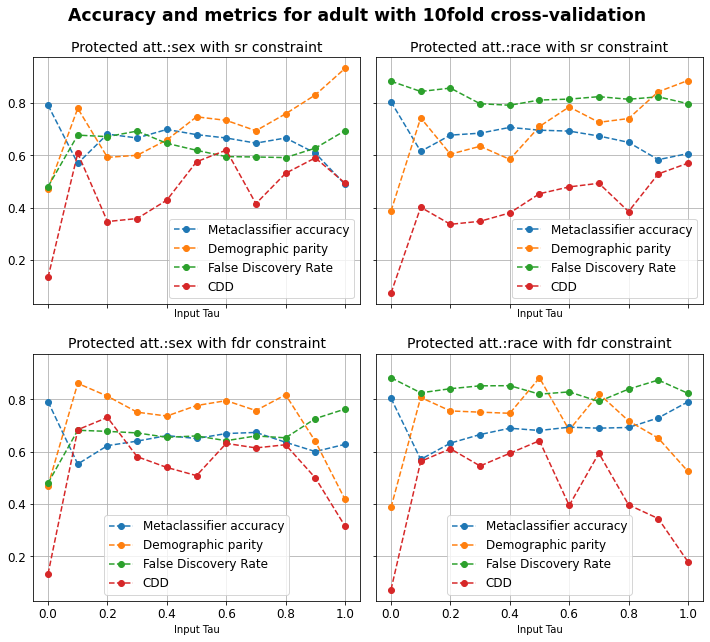

In [ ]:
case_study = 'adult'
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.05)

means = {}

axs = axs.ravel()

import itertools
tickers = [combo for combo in itertools.product(all_metrics[case_study].keys(), all_metrics[case_study]['sr'].keys())]

for ticker, i in zip(tickers, range(len(tickers))):

  means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr']['sex']['FDR'].columns,
                             columns = all_metrics[case_study]['sr']['sex'].keys())
  
  for metric in all_metrics[case_study]['sr']['sex'].keys():
    #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
    means_per_tau[metric] = all_metrics[case_study][ticker[0]][ticker[1]][metric].mean(axis=0)

  means[ticker] = means_per_tau

  accuracies, statistical_rates, fdr, CDD = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values, means_per_tau['CDD preds unpriv'] 
  all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]

  import matplotlib.pyplot as plt

  axs[i].plot(all_tau, accuracies, label = 'Metaclassifier accuracy', linestyle="--",marker="o")
  axs[i].plot(all_tau, statistical_rates, label = 'Demographic parity', linestyle="--",marker="o")
  axs[i].plot(all_tau, fdr, label = 'False Discovery Rate', linestyle="--",marker="o")
  axs[i].plot(all_tau, CDD, label = 'CDD', linestyle="--",marker="o")
  axs[i].set_xlabel('Input Tau')
  axs[i].tick_params(labelsize = 'large')
  axs[i].set_title('Protected att.:'+ticker[1]+' with '+ticker[0]+' constraint', fontsize=14)

  axs[i].legend(prop={'size':12})
  axs[i].grid()

folds = len(cases[case_study]['sr']['sex'].keys())
fig.suptitle('Accuracy and metrics for '+case_study+' with '+str(folds)+'fold cross-validation', y=0.95, fontsize='xx-large', fontweight='bold')
plt.savefig(path+"Figures/"+case_study+".pdf", format="pdf", bbox_inches="tight")
plt.show()

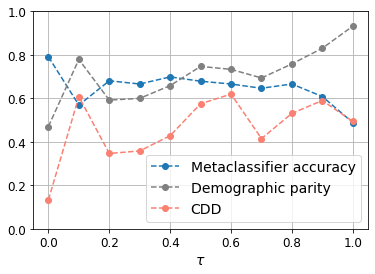

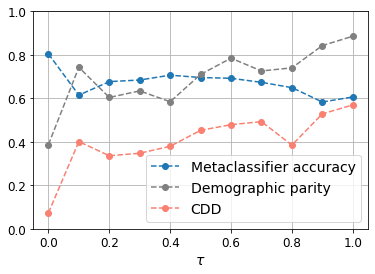

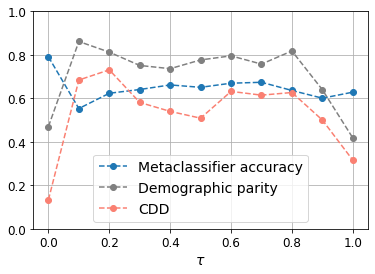

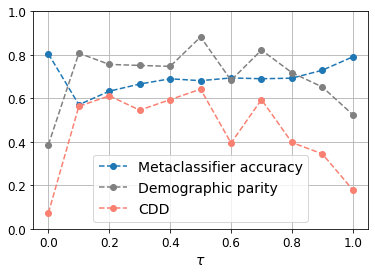

In [ ]:
case_study = 'adult'
means = {}

axs = axs.ravel()

import itertools
tickers = [combo for combo in itertools.product(all_metrics[case_study].keys(), all_metrics[case_study]['sr'].keys())]

for ticker, i in zip(tickers, range(len(tickers))):

  means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr']['sex']['FDR'].columns,
                             columns = all_metrics[case_study]['sr']['sex'].keys())
  
  for metric in all_metrics[case_study]['sr']['sex'].keys():
    #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
    means_per_tau[metric] = all_metrics[case_study][ticker[0]][ticker[1]][metric].mean(axis=0)

  means[ticker] = means_per_tau

  accuracies, statistical_rates, fdr, CDD = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values, means_per_tau['CDD preds unpriv'] 
  all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]

  import matplotlib.pyplot as plt

  plt.plot(all_tau, accuracies, label = 'Metaclassifier accuracy', linestyle="--",marker="o")
  plt.plot(all_tau, statistical_rates, label = 'Demographic parity', linestyle="--",marker="o", c='grey')
  #plt.plot(all_tau, fdr, label = 'False Discovery Rate', linestyle="--",marker="o", c='green')
  plt.plot(all_tau, CDD, label = 'CDD', linestyle="--",marker="o", c='salmon')
  plt.xlabel(r'$\tau$', size=14)
  plt.tick_params(labelsize = 'large',which='major')
  plt.ylim(bottom=0,top=1)
  #plt.title('Protected att.:'+ticker[1]+' with '+ticker[0]+' constraint', fontsize=14)

  plt.legend(prop={'size':14})
  plt.grid(visible=True)
  
  plt.savefig(path+"Figures/"+case_study+str(ticker[0])+str(ticker[1])+".pdf", format="pdf", bbox_inches="tight")
  #plt.suptitle('Accuracy and metrics for '+case_study+' with '+str(folds)+'fold cross-validation', y=0.95, fontsize='xx-large', fontweight='bold')
  plt.show()

Choose $τ$: 
- 0.7 under `sr` constraint for `sex`. 
- 0.7 under `sr` constraint for `race`.
- 0.8 under `fdr` constraint for `sex`.
- Striclty speaking, $τ$ shoud be 0.0 under `fdr` constraint for `race`, i.e. no bias mitigation is needed. However, FDR is a measure that does not consider (or is oblivious) the protected attribute in its computation. Therefore, we choose $τ = 0.8$ because `sr` is also in acceptable levels.

In [ ]:
cols = ['Dataset', 'Constraint', 'Protected att.', 'Best Classifier',  'Best accuracy', 'DP GT train',
        'DP GT test', 'CDD GT train unpriv', 'CDD GT train priv', 'CDD GT test unpriv', 'CDD GT test priv', 
        'Metaclass. accuracy', 'FDR AT', 'DP AT', 'CDD AT unpriv', 'CDD AT priv']
final_results = pd.DataFrame(columns=cols)

In [ ]:
adult_tau = [0.6, 0.7, 0.8, 0.8]

taus = []          
for key, tau in zip(means.keys(), adult_tau):
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols
  to_append['Chosen tau'] = str(tau)
  final_results = final_results.append(to_append)

for key, tau in zip(means.keys(), [0.0, 0.0, 0.0, 0.0]):
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols_0
  final_results_tau0 = final_results_tau0.append(to_append)

add_tau0 = final_results_tau0[final_results_tau0.columns[11:]].columns
final_results[add_tau0] = final_results_tau0[add_tau0].values

#### Titanic

In [ ]:
cases.keys(), cases['titanic_100']['sr'].keys()

(dict_keys(['compas_twoyear_100', 'titanic_100', 'adult_100']),
 dict_keys(['Sex', 'Class']))

In [ ]:
case_study = 'titanic_100'
s_attr = 'Sex' # race
constraint = 'sr' # fdr

means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr'][s_attr]['FDR'].columns,
                             columns = all_metrics[case_study]['sr'][s_attr].keys())
for metric in all_metrics[case_study]['sr'][s_attr].keys():
  #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
  means_per_tau[metric] = all_metrics[case_study][constraint][s_attr][metric].mean(axis=0)

In [ ]:
means_per_tau

,RandomForrest accuracy,DP ground truth train,DP ground truth test,Metaclass. accuracy,FDR,DP
Tau0.0,0.788499,0.264054,0.259512,0.804402,0.676707,0.061032
Tau0.1,0.788499,0.264054,0.259512,0.670407,0.232765,0.531669
Tau0.2,0.788499,0.264054,0.259512,0.718092,0.318981,0.427245
Tau0.3,0.788499,0.264054,0.259512,0.730712,0.353323,0.360992
Tau0.4,0.788499,0.264054,0.259512,0.731883,0.326153,0.385706
Tau0.5,0.788499,0.264054,0.259512,0.708753,0.311033,0.436110
Tau0.6,0.788499,0.264054,0.259512,0.667048,0.221474,0.630370
Tau0.7,0.788499,0.264054,0.259512,0.646056,0.206754,0.702585
Tau0.8,0.788499,0.264054,0.259512,0.610229,0.204333,0.781055
Tau0.9,0.788499,0.264054,0.259512,0.594733,0.195057,0.844161


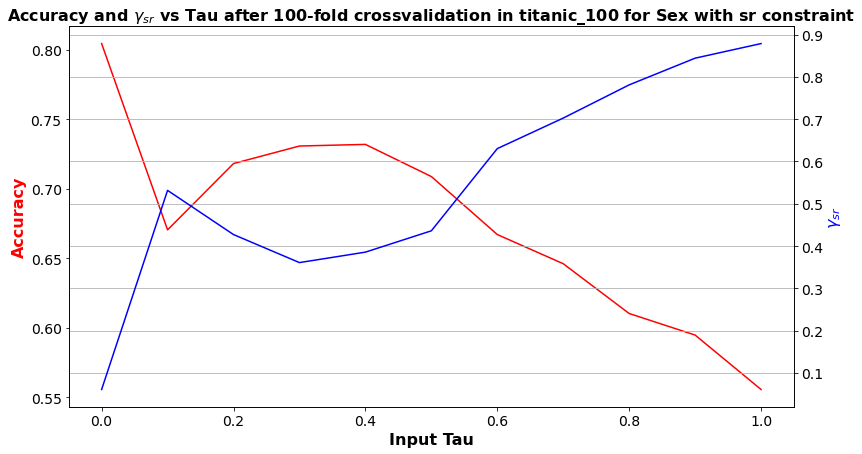

In [ ]:
accuracies, statistical_rates, fdr = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values
all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]
folds = len(cases[case_study]['sr'][s_attr].keys())

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_tau, accuracies, color='r')
ax1.set_title('Accuracy and $\gamma_{sr}$ vs Tau after '+str(folds)+'-fold crossvalidation in '+case_study+' for '+s_attr+' with '+constraint+' constraint', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input Tau', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_tau, statistical_rates, color='b')
ax2.set_ylabel('$\gamma_{sr}$', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

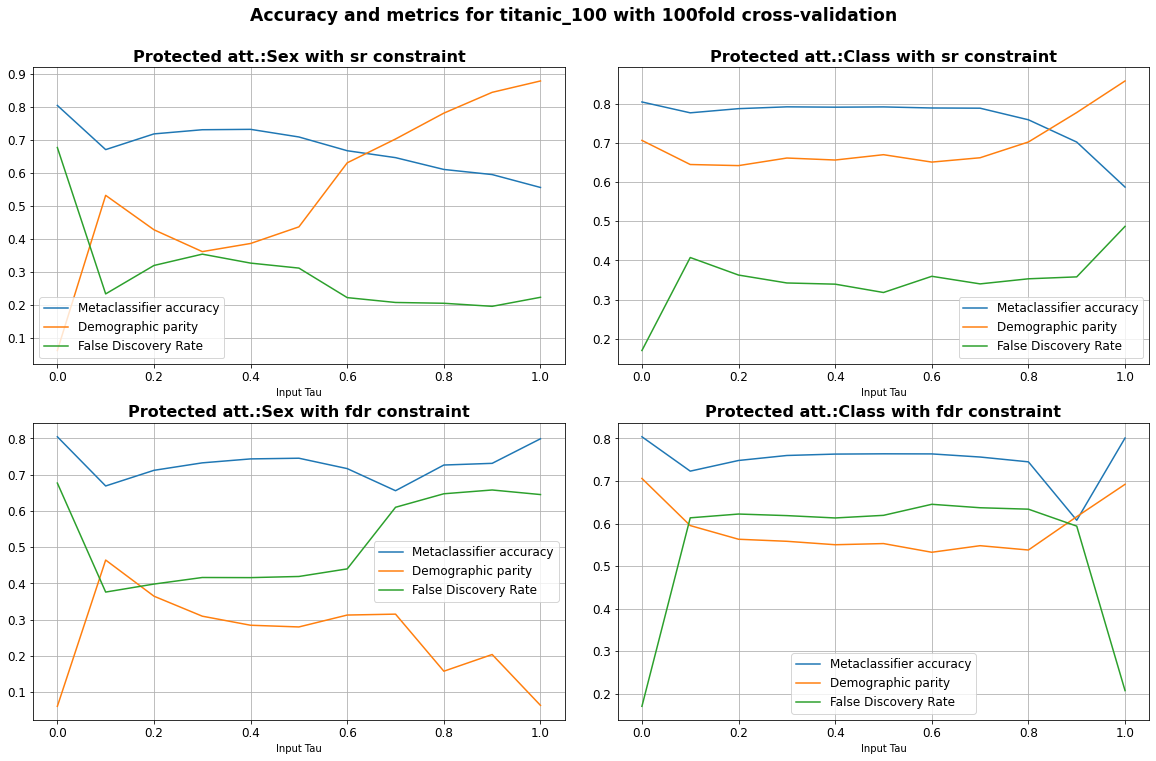

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.subplots_adjust(hspace = .2, wspace=.1)

axs = axs.ravel()

import itertools
tickers = [combo for combo in itertools.product(all_metrics[case_study].keys(), all_metrics[case_study]['sr'].keys())]

for ticker, i in zip(tickers, range(len(tickers))):

  means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr'][s_attr]['FDR'].columns,
                             columns = all_metrics[case_study]['sr'][s_attr].keys())
  
  for metric in all_metrics[case_study]['sr'][s_attr].keys():
    #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
    means_per_tau[metric] = all_metrics[case_study][ticker[0]][ticker[1]][metric].mean(axis=0)

  accuracies, statistical_rates, fdr = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values
  all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]

  import matplotlib.pyplot as plt

  axs[i].plot(all_tau, accuracies, label = 'Metaclassifier accuracy')
  axs[i].plot(all_tau, statistical_rates, label = 'Demographic parity')
  axs[i].plot(all_tau, fdr, label = 'False Discovery Rate')
  axs[i].set_xlabel('Input Tau')
  axs[i].tick_params(labelsize = 'large')
  axs[i].set_title('Protected att.:'+ticker[1]+' with '+ticker[0]+' constraint', fontsize=16, fontweight='bold')

  axs[i].legend(prop={'size':12})
  axs[i].grid()

folds = len(cases[case_study]['sr'][s_attr].keys())
fig.suptitle('Accuracy and metrics for '+case_study+' with '+str(folds)+'fold cross-validation', y=0.95, fontsize='xx-large', fontweight='bold')
plt.savefig(path+"Figures/"+case_study+".pdf", format="pdf", bbox_inches="tight")
plt.show()

To-dos: adding more metrics here might be interesting.

In [ ]:
results = pd.DataFrame(columns = ['dataset', 's_attribute', 'RF accuracy', 'Metaclass_accu_tau0', 'Metaclass_acc_besttau'])

In [ ]:
results

,dataset,protected_attribute,baseline,metaclassifier_accu_tau0,metaclassifier_accu_tau7,mitigation_types,dp_groundtruth_trainset,dp_groundtruth_testset,dp_preds_tau0,dp_preds_tau7,fdr_tau0,fdr_tau7
0,compas guess,sex,0.695935,0.731707,0.731707,sr,0.901894,0.983151,0.840883,0.804668,0.798161,0.800039
1,compas guess,sex,0.692141,0.730081,0.727371,sr,0.953221,0.866049,0.851945,0.892343,0.909346,0.959035
2,compas guess,sex,0.699187,0.727913,0.724661,sr,0.883060,0.964202,0.839025,0.921115,0.756995,0.813503
3,compas guess,sex,0.703523,0.721409,0.718157,sr,0.923433,0.931378,0.797440,0.690341,0.964388,0.808101
4,compas guess,sex,0.702439,0.731707,0.727913,sr,0.924136,0.928646,0.903376,0.886787,0.999394,0.945379
5,compas guess,sex,0.709485,0.728455,0.732791,sr,0.912204,0.965122,0.810708,0.819328,0.848688,0.843173
6,compas guess,sex,0.686721,0.723035,0.720867,sr,0.906809,0.972717,0.854658,0.792039,0.938205,0.830426
7,compas guess,sex,0.691599,0.714905,0.712737,sr,0.921342,0.936918,0.830201,0.752932,0.919645,0.861115
8,compas guess,sex,0.708401,0.730623,0.719783,sr,0.950576,0.868981,0.821660,0.729697,0.936152,0.892954
9,compas guess,sex,0.684553,0.721951,0.722493,sr,0.931927,0.911013,0.802968,0.872378,0.882655,0.924139


### Step by step

In [ ]:
# making my own metadata --------------------------------------------------
metadata_adult = {
    'unprivileged_metadata_prot': {
        'unprivileged':{'sex':'Female','race':'Non-white'},
        'privileged':{'sex':'Male','race':'White'}
            },
            'unprivileged_metadata_label': {
                'unfavorable':'<=50K',
                'favorable':'>50K'}
            }

unprivileged_metadata_prot, unprivileged_metadata_label = metadata_adult['unprivileged_metadata_prot'], metadata_adult['unprivileged_metadata_label']

metadata_compas = {
    'unprivileged_metadata_prot': {
        'unprivileged':{'sex':'Male','race':'Not Caucasian'},
        'privileged':{'sex':'Female','race':'Caucasian'}
            },
            'unprivileged_metadata_label': {
                'unfavorable':'Did recid.',
                'favorable':'No recid.'}
                }

unprivileged_metadata_prot, unprivileged_metadata_label = metadata_compas['unprivileged_metadata_prot'], metadata_compas['unprivileged_metadata_label']

In [ ]:
mitigation_type = 'sr' # or 'fdr'
tau_accuracy = True
dataset_orig = load_preproc_data_compas(label_name='compas_guess') # load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_titanic

In [ ]:
s_attr = "sex"

privileged_groups = [{s_attr: 1}]
unprivileged_groups = [{s_attr: 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed = 4)

In [ ]:
train_folds = []
test_folds = []
for fold in range(0,10):
  dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed = 100*fold)
  train_folds.append(dataset_orig_train)
  test_folds.append(dataset_orig_test)

Below are the indices the different train and test splits share.

In [ ]:
# crossvalidation performance
do_crossvalidation = False

if do_crossvalidation:
  import numpy as np
  for fold in range(0,10):
    print('common indices in train', np.intersect1d(train_folds[1].convert_to_dataframe()[0].index.values, train_folds[fold].convert_to_dataframe()[0].index.values).shape,
          'in test', np.intersect1d(test_folds[1].convert_to_dataframe()[0].index.values, test_folds[fold].convert_to_dataframe()[0].index.values).shape,
          'protected % per class train', train_folds[fold].convert_to_dataframe()[0][['sex','compas_guess']].value_counts(normalize='all').values,
          'test', test_folds[fold].convert_to_dataframe()[0][['sex','compas_guess']].value_counts(normalize='all').values)
    
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier()
    clf.fit(train_folds[fold].convert_to_dataframe()[0].iloc[:,:-1], train_folds[fold].convert_to_dataframe()[0].iloc[:,-1])
    acc_base_score = clf.score(test_folds[fold].convert_to_dataframe()[0].iloc[:,:-1], test_folds[fold].convert_to_dataframe()[0].iloc[:,-1])
    print('accuracy:', acc_base_score)

    baseline.append(acc_base_score)

common indices in train (2999,) in test (539,) protected % per class train [0.40650407 0.39883856 0.10894309 0.08571429] test [0.40650407 0.38699187 0.10406504 0.10243902]
accuracy: 0.6937669376693767
common indices in train (4305,) in test (1845,) protected % per class train [0.40441347 0.39790941 0.10452962 0.0931475 ] test [0.40867209 0.39186992 0.11273713 0.08672087]
accuracy: 0.6818428184281843
common indices in train (2991,) in test (531,) protected % per class train [0.40511034 0.39837398 0.11033682 0.08617886] test [0.40596206 0.39186992 0.10298103 0.09918699]
accuracy: 0.699728997289973
common indices in train (3006,) in test (546,) protected % per class train [0.40441347 0.40023229 0.10522648 0.09012776] test [0.40162602 0.39349593 0.11111111 0.09376694]
accuracy: 0.7018970189701897
common indices in train (3004,) in test (544,) protected % per class train [0.40464576 0.39953542 0.10662021 0.08919861] test [0.40487805 0.39132791 0.10785908 0.09593496]
accuracy: 0.693766937669

In [ ]:
# baseline

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(dataset_orig_train.convert_to_dataframe()[0].iloc[:,:-1], dataset_orig_train.convert_to_dataframe()[0].iloc[:,-1])
acc_base_score = clf.score(dataset_orig_test.convert_to_dataframe()[0].iloc[:,:-1], dataset_orig_test.convert_to_dataframe()[0].iloc[:,-1])
print(acc_base_score)

0.6845528455284553


Careful: in compas, the favorable, unfavorable labels are switched. needs to be fixed

In [ ]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)

display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(4305, 10)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count=0 to 2', 'priors_count=3 to 8', 'priors_count=More than 8', 'charge_degree (misd/fel)=0', 'charge_degree (misd/fel)=1']


In [ ]:
from binary_label_dataset_metric import BinaryLabelDatasetMetric

TO-DO: crossvalidation? Magali?

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)


dpratio_train = min(metric_orig_train.disparate_impact(), 1/metric_orig_train.disparate_impact())
print("Train set: Statistical parity = {:.3f}".format(dpratio_train))

dpratio_test = min(metric_orig_test.disparate_impact(), 1/metric_orig_test.disparate_impact())
print("Test set: Statistical parity = {:.3f}".format(dpratio_test))

Train set: Statistical parity = 0.902
Test set: Statistical parity = 0.983


In [ ]:
def data_for_cdd(dataset, Rs, include_predictions = False, predictions = None):
  df = dataset.convert_to_dataframe()[0]

  # undummify R in test set
  col_list = list(df.columns)
  undumify = df[[col for col in col_list if Rs[0].lower() in col.lower()]]

  undumify.index.name = 'ID'
  undumify = undumify[undumify==1].stack().reset_index().drop(0, axis=1)
  undumify.set_index('ID',inplace=True)

  undumify[dataset.label_names[0]] = df[dataset.label_names[0]].replace(dataset.metadata['label_maps'][0])
  #undumify[dataset_orig_test.label_names[0]] = dataset_orig_test.convert_to_dataframe()[0][dataset_orig_test.label_names[0]]

  if dataset.metadata['protected_attribute_maps'][0][0].lower() in ['male','female']:
    undumify['sex'] = df['sex'].replace(dataset.metadata['protected_attribute_maps'][0])

  if dataset.metadata['protected_attribute_maps'][1][0].lower() in ['white', 'caucasian', 'black', 'non-white', 'not caucasian']:
    undumify['race'] = df['race'].replace(dataset.metadata['protected_attribute_maps'][1])

  undumify.rename(columns={'level_1':Rs[0]}, inplace=True)

  if include_predictions:
    undumify[dataset.label_names[0]] = pd.DataFrame(predictions.labels,index=df.index).replace(dataset.metadata['label_maps'][0])

  return undumify

In [ ]:
def cdd(data, dataset, prots):

  Ys = dataset.label_names
  prots = prots #dataset.protected_attribute_names

  cdd_sizes = {}

  # Make Table 1 and  in Wachter
  for Y in Ys:
    cdd_sizes[Y] = {}
    for prot in prots:
      cdd_sizes[Y][prot] = {}
      for R in Rs:
        
        cdd_data = pd.DataFrame(np.array([data[Y].values, data[R], data[prot]]).T, columns = ['Label', R, prot])

        sizes = pd.DataFrame(cdd_data.groupby([prot,'Label',R]).size(), columns = ['Number '+Y])
        sizes['Rate '+Y] = round(sizes / sizes.groupby(['Label',R]).transform('sum'),2)
        cdd_sizes[Y][prot][R] = pd.DataFrame(sizes)
  
  # Aggregate as in Table 3 of Wachter
  cdd = {}
  for Y in Ys: # In case we have multiple target
    cdd[Y] = {}
    for R in Rs: # For multiple conditions
      cdd[Y][R] = {}
      for prot in prots: # For multiple protected features
        pivot = cdd_sizes[Y][prot][R].reset_index().pivot(columns = ['Label', prot], index = R, values = ['Rate '+Y])
        cdd_row = []
        for pair in pivot.columns:
          group_label = pd.DataFrame(pivot[pair[0]][pair[1]][pair[2]])
          
          weights = pd.DataFrame(np.unique(data[R], return_counts=True)).T
          weights.columns = [R, 'Weights']
          weights.set_index(R, inplace = True)

          group_label['Weights'] = weights['Weights']
          group_label.fillna(0, inplace=True)

          #print(pair, sum(group_label['Weights']), len(data[R]))

          cdd_agg = round(sum(group_label[pair[2]] * group_label['Weights']) / len(data[R]),2)
          cdd_row.append(cdd_agg)

        pivot.loc['All'] = np.array(cdd_row)
        cdd[Y][R][prot] = pivot
  
  cdd_agg_tables = {}
  final_ratios = {}

  for prot in prots:
    cdd_ratio = pd.DataFrame(cdd[dataset.label_names[0]][Rs[0]][prot].iloc[-1,:]).T
    cdd_agg_tables[prot] = cdd_ratio

    try:
      unfav_unpriv = cdd_ratio[('Rate '+dataset.label_names[0], 
            unprivileged_metadata_label['unfavorable'], 
            unprivileged_metadata_prot['unprivileged'][prot])][0]
    except KeyError:
      unfav_unpriv = 0

    try:        
      fav_unpriv = cdd_ratio[('Rate '+dataset.label_names[0], 
              unprivileged_metadata_label['favorable'], 
              unprivileged_metadata_prot['unprivileged'][prot])][0]
    except KeyError:
      fav_unpriv = 0

    #print('unpriviledged', prot, unprivileged_metadata_prot['unprivileged'][prot], min(unfav_unpriv,fav_unpriv) / max(unfav_unpriv,fav_unpriv), end=', ')

    try:
      unfav_priv = cdd_ratio[('Rate '+dataset.label_names[0], 
            unprivileged_metadata_label['unfavorable'], 
            unprivileged_metadata_prot['privileged'][prot])][0] 
    except KeyError:
      unfav_priv = 0

    try:     
     fav_priv = cdd_ratio[('Rate '+dataset.label_names[0], 
              unprivileged_metadata_label['favorable'], 
              unprivileged_metadata_prot['privileged'][prot])][0]
    except KeyError:
      fav_priv = 0

    final_ratios[prot] = pd.DataFrame(data={unprivileged_metadata_prot['unprivileged'][prot]:min(unfav_unpriv,fav_unpriv) / max(unfav_unpriv,fav_unpriv),
                                            unprivileged_metadata_prot['privileged'][prot]: min(unfav_priv,fav_priv) / max(unfav_priv,fav_priv)}, index=[prot])
  
  #print('priviledged', prot, unprivileged_metadata_prot['privileged'][prot], min(unfav_priv,fav_priv) / max(unfav_priv,fav_priv))

  return final_ratios, cdd_agg_tables, cdd, cdd_sizes

In [ ]:
dataset_orig_train

In [ ]:
# compute CDD on ground truth
Rs = ['priors'] # or education
cdd_df = data_for_cdd(dataset_orig_train, Rs)
cdd_ratios_train, cdd_agg_train, _, _ = cdd(cdd_df, dataset_orig_train, [s_attr])

print('Train set CDD: \n', cdd_ratios_train[s_attr])
print()

cdd_df = data_for_cdd(dataset_orig_test, Rs)
cdd_ratios_test, cdd_agg_test, all, _ = cdd(cdd_df, dataset_orig_test, [s_attr])

print('Test set CDD: \n', cdd_ratios_test[s_attr])

Train set CDD: 
          Male  Female
sex  0.987654    0.95

Test set CDD: 
          Male    Female
sex  0.951807  0.809524


In [ ]:
from aif360.algorithms.inprocessing.exponentiated_gradient_reduction import ExponentiatedGradientReduction
from aif360.algorithms.inprocessing.grid_search_reduction import GridSearchReduction

In [ ]:
biased_model = MetaFairClassifier(tau=0, sensitive_attr=s_attr, type=mitigation_type).fit(dataset_orig_train)
dataset_bias_test = biased_model.predict(dataset_orig_test)
dataset_bias_test

Careful: `disparate impact` folmula gives different results than the `statistical_parity_difference` even though it's the same mathematicaln equation. I will use `statistical_parity_difference` for now but this needs to be further investigated. 

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(dataset_orig_test.labels.flatten(), dataset_bias_test.labels.flatten())

In [ ]:
# compute CDD on predictions with tau0
Rs = ['priors']
cdd_df = data_for_cdd(dataset_bias_test, Rs, include_predictions = True, predictions = dataset_bias_test)
cdd_ratios_preds, cdd_agg_preds, all, sizes = cdd(cdd_df, dataset_bias_test, [s_attr])

print('Predictions CDD: \n', cdd_ratios_preds[s_attr])
print()

Predictions CDD: 
          Male  Female
sex  0.963855    0.85



Problem for cdd and predictions: some groups are 0.

In [ ]:
dataset_bias_test

In [ ]:
classified_metric_bias_test = ClassificationMetric(dataset_orig_test, dataset_bias_test,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
print("Test set: Classification accuracy = {:.3f}".format(classified_metric_bias_test.accuracy()))
TPR = classified_metric_bias_test.true_positive_rate()
TNR = classified_metric_bias_test.true_negative_rate()
bal_acc_bias_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_bias_test))
dpratio = min(classified_metric_bias_test.disparate_impact(), 1/classified_metric_bias_test.disparate_impact())
print("Test set: Disparate impact = {:.3f}".format(dpratio))
print("Test set: Statistical parity difference = {:.3f}".format(classified_metric_bias_test.statistical_parity_difference()))
fdr = classified_metric_bias_test.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))

TypeError: ignored

In [ ]:
debiased_model = MetaFairClassifier(tau=0.7, sensitive_attr=s_attr, type=mitigation_type).fit(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = {:.3f}".format(metric_dataset_debiasing_test.mean_difference()))

Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.139


In [ ]:
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = {:.3f}".format(classified_metric_debiasing_test.accuracy()))
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_debiasing_test))
dpratio = min(classified_metric_debiasing_test.disparate_impact(), 1/classified_metric_debiasing_test.disparate_impact())
print("Test set: Disparate impact = {:.3f}".format(dpratio))
print("Test set: Statistical parity difference = {:.3f}".format(classified_metric_debiasing_test.statistical_parity_difference()))
fdr = classified_metric_debiasing_test.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))


Test set: Classification accuracy = 0.709
Test set: Balanced classification accuracy = 0.712
Test set: Disparate impact = 0.737
Test set: Statistical parity difference = -0.139
Test set: False discovery rate ratio = 0.674


In [ ]:
# compute CDD on predictions with chosen tau
Rs = ['priors']
cdd_df = data_for_cdd(dataset_debiasing_test, Rs, include_predictions = True, predictions = dataset_debiasing_test)
cdd_ratios_preds, cdd_agg_preds, all, sizes = cdd(cdd_df, dataset_debiasing_test, [s_attr])

print('Predictions CDD: \n', cdd_ratios_preds[s_attr])
print()

Predictions CDD: 
          Male    Female
sex  0.964286  0.842105



100%|██████████| 11/11 [00:25<00:00,  2.28s/it]


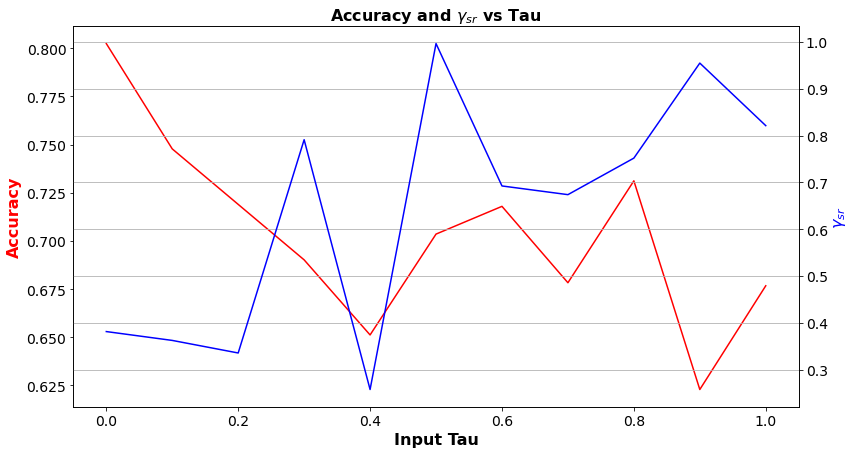

In [ ]:
tau_accuracy = True
if tau_accuracy:
  accuracies, statistical_rates = [], []

  all_tau = np.linspace(0, 1, 11)
  for tau in tqdm(all_tau):
      debiased_model = MetaFairClassifier(tau=tau, sensitive_attr=s_attr, type=mitigation_type)
      debiased_model.fit(dataset_orig_train)

      dataset_debiasing_test = debiased_model.predict(dataset_orig_test)
      metric = ClassificationMetric(dataset_orig_test, dataset_debiasing_test,
                                    unprivileged_groups=[{s_attr: 0}],
                                    privileged_groups=[{s_attr: 1}])

      accuracies.append(metric.accuracy())
      sr = metric.disparate_impact()
      statistical_rates.append(min(sr, 1/sr))

  import matplotlib.pyplot as plt

  fig, ax1 = plt.subplots(figsize=(13,7))
  ax1.plot(all_tau, accuracies, color='r')
  ax1.set_title('Accuracy and $\gamma_{sr}$ vs Tau', fontsize=16, fontweight='bold')
  ax1.set_xlabel('Input Tau', fontsize=16, fontweight='bold')
  ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
  ax1.xaxis.set_tick_params(labelsize=14)
  ax1.yaxis.set_tick_params(labelsize=14)

  ax2 = ax1.twinx()
  ax2.plot(all_tau, statistical_rates, color='b')
  ax2.set_ylabel('$\gamma_{sr}$', color='b', fontsize=16, fontweight='bold')
  ax2.yaxis.set_tick_params(labelsize=14)
  ax2.grid(True)

### Metaclassifier results

Compare random forest and naive base performance. 

In [ ]:
cases.keys()

dict_keys(['compas_twoyear', 'titanic', 'adult', 'compas_guess'])

In [ ]:
xlsx_sheets = {'adult':'adult_all features', 
               'compas_twoyear': 'broward_all features_two_year', 
               'compas_guess':'broward_all features_compas_gue'}

hp = pd.read_excel(path+'hp_output.xlsx', sheet_name='adult_all features')

best_clasifiers = []
best_accuracies = []

for dataset in final_results['Dataset'].unique():
  hp = pd.read_excel(path+'hp_output.xlsx', sheet_name=xlsx_sheets[dataset])
  best_accuracy = hp[['mean_test_accuracy', 'param_classifier']].sort_values('mean_test_accuracy', ascending=False).iloc[0,:]['mean_test_accuracy']
  best_clasifier = hp[['mean_test_accuracy', 'param_classifier']].sort_values('mean_test_accuracy', ascending=False).iloc[0,:]['param_classifier']

  number = len(final_results[final_results['Dataset'] == dataset][['Best Classifier', 'Best accuracy']])

  for i in range(number):
    best_accuracies.append(np.round(best_accuracy,2))
    best_clasifiers.append(best_clasifier)

final_results['Best Classifier'] = best_clasifiers
final_results['Best accuracy'] = best_accuracies

In [ ]:
import pickle 

#with open(path+'_cdd_pretraining.pkl', 'wb') as f:
#    pickle.dump(all_cdd, f)

for file_name in glob.glob(path+'_cdd_pretraining.pkl'):
  f = open(file_name, 'rb')
  loaded_dict = pickle.load(f)
  cdd_ground_truth = loaded_dict

In [ ]:
# I gotta make a function out of this

cdd_sizes = {}
Rs = ['education', 'occupation']
Y = 'income'
prots = ['sex', 'race']

for prot in prots:
  cdd_sizes[prot] = {}
  for R in Rs:
    
    cdd_data = pd.DataFrame(np.array([df[Y].values, df[R], df[prot]]).T, columns = ['Label', R, prot])

    sizes = pd.DataFrame(cdd_data.groupby([prot,'Label',R]).size(), columns = ['Number '+Y])
    sizes['Rate '+Y] = round(sizes / sizes.groupby(['Label',R]).transform('sum'),2)
    cdd_sizes[prot][R] = pd.DataFrame(sizes)

cdd = {}
for R in Rs:
  cdd[R] = {}
  for prot in prots:
    pivot = cdd_sizes[prot][R].reset_index().pivot(columns = ['Label', prot], index = R, values = ['Rate income'])
    cdd_row = []
    for pair in pivot.columns:
      group_label = pd.DataFrame(pivot[pair[0]][pair[1]][pair[2]])
      
      weights = pd.DataFrame(np.unique(df[R], return_counts=True)).T
      weights.columns = [R, 'Weights']
      weights.set_index(R, inplace = True)

      group_label['Weights'] = weights['Weights']
      group_label.fillna(0, inplace=True)

      cdd_agg = round(sum(group_label[pair[2]] * group_label['Weights']) / len(df[R]),2)
      cdd_row.append(cdd_agg)

      #print(cdd_agg, end = ' | ')
      #print(pair[1:])
    pivot.loc['All'] = np.array(cdd_row)
    cdd[R][prot] = pivot

In [ ]:
loaded_dict['compas']['sex']

Rate two_year_recid                   
Label                            0      1     0     1
sex                         Female Female  Male  Male
two_year_recid                0.21   0.16  0.79  0.84
compas_guess                  0.19   0.20  0.81  0.80

In [ ]:
final_results.columns

Index(['Dataset', 'Constraint', 'Protected att.', 'Best Classifier',
       'Best accuracy', 'DP GT train', 'DP GT test', 'CDD GT train unpriv',
       'CDD GT train priv', 'CDD GT test unpriv', 'CDD GT test priv',
       'Metaclass. accuracy', 'FDR AT', 'DP AT', 'CDD AT unpriv',
       'CDD AT priv', 'Chosen tau', 'Metaclass. accuracy Tau0', 'FDR AT Tau0',
       'DP AT Tau0', 'CDD AT unpriv Tau0', 'CDD AT priv Tau0'],
      dtype='object')

In [ ]:
final_results[(final_results['Dataset'] == 'compas_twoyear') & 
              (final_results['Constraint'] == 'sr')][['Protected att.','DP GT train', 'CDD GT train unpriv',
                                                                 'CDD GT test unpriv','DP GT test', 'Metaclass. accuracy','FDR AT', 
                                                                 'DP AT', 'CDD AT unpriv', 
                                                                 'Metaclass. accuracy Tau0', 'FDR AT Tau0', 'DP AT Tau0',
                                                                 'CDD AT unpriv Tau0']].to_latex(index=False)

'\\begin{tabular}{lllllllllllll}\n\\toprule\nProtected att. & DP GT train & CDD GT train unpriv & CDD GT test unpriv & DP GT test & Metaclass. accuracy & FDR AT & DP AT & CDD AT unpriv & Metaclass. accuracy Tau0 & FDR AT Tau0 & DP AT Tau0 & CDD AT unpriv Tau0 \\\\\n\\midrule\n           sex &         0.8 &                0.93 &               0.93 &        0.8 &                0.64 &   0.81 &  0.82 &          0.58 &                     0.66 &        0.78 &       0.79 &               0.83 \\\\\n          race &         0.8 &                0.89 &               0.89 &        0.8 &                0.62 &   0.82 &  0.82 &          0.57 &                     0.67 &        0.84 &       0.72 &               0.71 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
final_results[(final_results['Dataset'] == 'compas_guess') & 
              (final_results['Constraint'] == 'sr')][['Protected att.','DP GT train', 'CDD GT train unpriv',
                                                                 'CDD GT test unpriv','DP GT test', 'Metaclass. accuracy','FDR AT', 
                                                                 'DP AT', 'CDD AT unpriv', 'Chosen tau',
                                                                 'Metaclass. accuracy Tau0', 'FDR AT Tau0', 'DP AT Tau0',
                                                                 'CDD AT unpriv Tau0']]

,Protected att.,DP GT train,CDD GT train unpriv,CDD GT test unpriv,DP GT test,Metaclass. accuracy,FDR AT,DP AT,CDD AT unpriv,Chosen tau,Metaclass. accuracy Tau0,FDR AT Tau0,DP AT Tau0,CDD AT unpriv Tau0
0,sex,0.92,0.98,0.97,0.93,0.67,0.84,0.82,0.71,0.9,0.73,0.9,0.84,0.98
0,race,0.63,0.72,0.73,0.64,0.69,0.65,0.72,0.62,0.8,0.73,0.66,0.58,0.63


**Discuss results**

- `metaclassifier_accu_tau7` should be lower but similar to `metaclassifier_accu_tau0`. This means that the classifier is still useful considering the bias constraints.
- `baseline` is random forest here. I included it because it a more powerful classifier compared to Naive Bayes which is used by the classifier. Therefore, `baseline` and `metaclassifier_accu` should be similar.
- `dp_groundtruth_trainset`: demographic parity computed on the ground truth of the training set. This is a ratio, which means that the optimal value is 1. 1 means group fairness is reached.

## Implicit bias

In [ ]:
!pip install bfcm

In [ ]:
import bfcm

In [ ]:
import sys
import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=2.5, rc=paper_rc)
                   
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
file = 'https://raw.githubusercontent.com/gnapoles/implicit-bias/main/german_association_matrix.csv'

df = abs(pd.read_csv(file))
W0 = df.to_numpy().reshape(len(df.columns), len(df.columns))

names = df.columns.tolist()

In [ ]:
case = "age"
phi_values = [1.0, 0.9, 0.8, 0.5]
fig, ax= plt.subplots(2, 2, figsize=(18, 12))
grid = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for i in range(len(phi_values)):
    
    df = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(20):
        
        f9 = np.random.uniform(0.0,1.0)
        f14 = np.random.uniform(0.0,1.0)
        f15 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, 0, 0, 0, f9, 0, 0, 0, 0, f14, f15, 0, 0, 0, 0, 0]])
        
        state = bfcm.reasoning(W0, A, T=21, phi=phi_values[i])

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["feature"] = "Age"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["feature"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["var","iteration","value"])
        df3["iteration"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["feature"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    ax1 = sns.lineplot(data=df, x="iteration", y="value", hue="feature", ax=grid[i], marker='o')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    grid[i].set_title('phi=' + str(phi_values[i]))
    grid[i].set_ylabel(None)
    grid[i].set_xlabel(None)
    
    grid[i].set_ylim([0, 0.35])
    grid[i].legend(loc='best')
    plt.ylim(0, 0.35)
    
    fig.tight_layout()
    plt.savefig('age.pdf')

In [ ]:
0.3/0.7 

## Other Measures Results

### Other metrics - Group Fairness

Some notes:  
(1) In Dutch dataset, removing or including the protected feature `sex` (see last column `Prot in X`) when training the classifier makes a clear difference in the measures' outcomes.  
(2) Compas dataset produces similar results when comparing the three different versions of the dataset. What is interesting is that when predicting the ground truth (`two_year_recid`) in `Broward` dataset, there is slightly more bias agaist sex that gender. Still though, the absolute amount of measures bias is lower compared to `Dutch` ad `Titanic` datasets. This means that COMPAS's decision making process seems to be relatively fair.  
(3) In Titanic dataset, there is a clear bias against men.

In [ ]:
# group fairness metrics
metrics_results

### Other metrics - Individual Fairness

In [ ]:
path1 = '/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa/FRU measure/'
sys.path.append(path1)

In [ ]:
import fru_main as fru

In [ ]:
# initialize objects
dataset_info = [] # dataset name
consistency = [] # consistency scores before and after excluding protected features
generalized_entropy = [] # GEE before and after excluding protected features
theil_indx = []
coefficient_of_var = []

This is still slow when there dataset is larger than 6k instances. Ideas to fix: move to C++, instead of looping over single instances calculate over a greater number of instaces, say 1000, try h5py or pyTables

In [ ]:
df.columns

In [ ]:
fru.fru(df, ['sex'], dataset, path1)

## Supplementary analysis

In [ ]:
# Northpoint cox-parsed dataset as provided by Propublica
# this analysis shoud be included in supplementary material
case = 'cox_parsed'

df = pd.read_csv(path+'cox-parsed.txt')
df.drop(df['score_text'][df['score_text'].isna()].index, axis=0, inplace=True) # drop NAs
df.drop(df[df.end < df.start].index, axis=0, inplace=True) # drop end that is bigger than start
df.drop_duplicates(subset=['id'], inplace=True) # drop duplicates

fig, ax =plt.subplots(1,3)
plt.rcParams["figure.figsize"] = [20, 3]
sns.histplot(data=df, x='score_text', hue = 'is_recid', multiple='dodge', stat = 'density', ax=ax[0])
sns.histplot(data=df, x='decile_score.1', hue = 'is_recid', multiple='dodge', stat = 'density', ax=ax[1])
sns.histplot(data=df, x='decile_score.1', hue = 'score_text', multiple='dodge', stat = 'density', ax=ax[2])
fig.show()

from scipy.stats import spearmanr, kendalltau
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

dec_score = df[['decile_score.1', 'score_text']]

enc = LabelEncoder()
dec_score.loc[:,'score_text'] = enc.fit_transform(dec_score['score_text']).reshape((-1,1))
scaler = MinMaxScaler()
dec_score.loc[:,['decile_score.1', 'score_text']] = scaler.fit_transform(dec_score)

print('correlation between decile score and score text')
print('Pearson:', dec_score.corr().iloc[0, 1])
print('Spearman:', spearmanr(dec_score))
print('KendalTau:', kendalltau(dec_score['decile_score.1'], dec_score['score_text']))

In [ ]:
df = pd.read_csv(path+'compas-scores-two-years.txt', index_col=0)
df.head()

In [ ]:
df.columns

In [ ]:
sns.histplot(x = 'two_year_recid', hue='is_recid', data = df, multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.show()

In [ ]:
sns.histplot(x = 'compas_decile_score', hue='compas_guess', data = df, multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.show()

In `Broward_Clean`, `compas_decile_score` and `compas_guess` are again the same variable. The first should not be used as a predictor.

In [ ]:
sns.histplot(x = 'compas_decile_score', hue='compas_guess', data = df, multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.show()

In [ ]:
# compute cdd manually

R = 'Marital_status'
print('         Positive label   Negative label    ')
print('         _______________  __________________')
print('Status   Male  Female     Male   Female     ')

for status in df[R].unique():
  A_R_unprot = np.str(np.round(np.sum((df[target] == pos_label) & (df[prot] == priv_group) & (df[R] == status)) / np.sum((df[target] == pos_label) & (df[R] == status)),2))
  A_R_prot = np.str(np.round(np.sum((df[target] == pos_label) & (df[prot] == unpriv_group) & (df[R] == status)) / np.sum((df[target] == pos_label) & (df[R] == status)),2))
  
  D_R_unprot = np.str(np.round(np.sum((df[target] == neg_label) & (df[prot] == priv_group) & (df[R] == status)) / np.sum((df[target] == neg_label) & (df[R] == status)),2))
  D_R_prot = np.str(np.round(np.sum((df[target] == neg_label) & (df[prot] == unpriv_group) & (df[R] == status)) / np.sum((df[target] == neg_label) & (df[R] == status)),2))
  
  print(status+'        '+A_R_unprot+'  '+A_R_prot+'       '+D_R_unprot+'  '+D_R_prot)

To build the KL divergence, we need to define an ideal distribution based on on groups (see the [denominators in Skews metrics](https://github.com/linkedin/LiFT/blob/main/dataset-fairness.md)). Do we want to make such definitions? I will define that to achieve gender fairness, 50% of men and 50% of women should survive.

I tried to make my own function but it does not align with AIF360.
Sad. Maybe I can revert to it.... Links:
https://github.com/linkedin/LiFT/blob/main/dataset-fairness.md
https://towardsdatascience.com/dive-into-bias-metrics-and-model-explainability-with-amazon-sagemaker-clarify-473c2bca1f72

In [ ]:
# kldivergence
def kldivergence(df, target, prot, pos_label, neg_label, priv_group, unpriv_group, expected = 0.5):

  # Skew formulas in https://github.com/linkedin/LiFT/blob/main/dataset-fairness.md
  # specify ideal rate for expected statistics. refers to the protected attribute

  # positive label statistics & protected feature
  true_positives_priv_group = np.sum((df[target] == pos_label) & (df[prot] == priv_group))
  true_positives_unpriv_group = np.sum((df[target] == pos_label) & (df[prot] == unpriv_group))
  ideal_positives_priv_group = math.floor(np.sum(df[prot] == priv_group) * expected)
  ideal_positives_unpriv_group = math.floor(np.sum(df[prot] == unpriv_group) * expected)

  group_sizes = pd.DataFrame(np.array([[np.sum(df[prot] == priv_group), np.sum(df[prot] == unpriv_group)],
                        [true_positives_priv_group, true_positives_unpriv_group],
                        [ideal_priv_group, ideal_unpriv_group]]),
              columns = ['Priviledged group', 'Unpriviledged group'], 
              index = ['Total', 'Observed', 'Expected'])

  from itertools import product
  sum_x = 0
  skews = np.array([['Observed', 'Log. difference', 'Group', 'Label', 'Expected']])

  for group, label in list(product([priv_group, unpriv_group], [pos_label])): # maybe remove neg_label from second list
    observed = np.sum((df[target] == label) & (df[prot] == group)) / np.sum(df[prot] == group) # How to normalize here? What is the denominator? maybe np.sum(df[prot] == group) or len(df) or 
    logarithmic_difference = np.round(np.log(observed/expected),2)
    skews = np.concatenate((skews, np.array([[np.round(observed,2), logarithmic_difference, group, label, expected]])), axis=0)
    sum_x += observed * logarithmic_difference

  return round(sum_x,2), pd.DataFrame(skews[1:], columns=skews[0]), group_sizes

In [ ]:
def compute_kl_div(y_pred, y_true, pos_label, neg_label, priv_group, unpriv_group, class_order, binarize_protected = True):

  if y_pred

  kl = []
  info = []

  window = len(class_order)-1
  labels = [pos_label, neg_label]

  # to compute kl_div, aif360 requires both binary target and binary protected class.
  # if target it ordered and multiclass

  for idx, item in enumerate(class_order):
    if (window + idx) > len(class_order):
      break
    else:
      group = class_order[idx:idx+window]
      split = [item for item in class_order if item not in class_order[idx:idx+window]][0]
      labels.remove(split)

      binary_pred = y_pred.where(y_pred == split, labels[0])
      binary_test = y_true.where(y_true == split, labels[0])

      if binarize_protected:
        new_index = {item:priv_group for item in binary_pred.index.unique() if item != unpriv_group}
        binary_pred = binary_pred.rename(index=new_index)
        binary_test = binary_test.rename(index=new_index)

      kld = kl_divergence(
          y_true = binary_test[(binary_test.index == priv_group) ^ (binary_test.index == unpriv_group)],
          y_pred = binary_pred[(binary_pred.index == priv_group) ^ (binary_pred.index == unpriv_group)],
          priv_group=priv_group)
      kl.append(round(kld,2))
      info.append(str([group, 'grouped as:', labels[0], 'remaining label:' ,split, 'protected feature binary', binarize_protected]))

    labels = [pos_label, neg_label]
    
  return str(kl), info

### Crossvalidation analysis aif360 vs sklearn

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/PhD/Bias detection & mitigation/Legal principles and AI/Lisa/metaclassifier_aif360/')

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from tqdm import tqdm

#from aif360.metrics import BinaryLabelDatasetMetric
#from aif360.metrics import ClassificationMetric

from aif360.algorithms.inprocessing import MetaFairClassifier

np.random.seed(12345)

#from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
#dataset_orig = load_preproc_data_adult()

In [ ]:
import adult_dataset, compas_dataset, titanic_dataset
import binary_label_dataset, binary_label_dataset_metric
import classification_metric
import data_preproc_functions
import dataset, dataset_metric, metric
import standard_dataset, structured_dataset

In [ ]:
from data_preproc_functions import load_preproc_data_compas, load_preproc_data_adult, load_preproc_data_titanic

In [ ]:
mitigation_type = 'sr' # or 'fdr'
tau_accuracy = False
dataset_orig = load_preproc_data_compas(label_name='compas_guess') # load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_titanic

In [ ]:
train_folds = []
test_folds = []
for fold in range(0,10):
  dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed = 100*fold)
  train_folds.append(dataset_orig_train)
  test_folds.append(dataset_orig_test)

Below are the indices the different train and test splits share.

In [ ]:
import numpy as np
for fold in range(0,10):
  print('common indices in train', np.intersect1d(train_folds[1].convert_to_dataframe()[0].index.values, train_folds[fold].convert_to_dataframe()[0].index.values).shape,
        'in test', np.intersect1d(test_folds[1].convert_to_dataframe()[0].index.values, test_folds[fold].convert_to_dataframe()[0].index.values).shape,
        'protected % per class train', train_folds[fold].convert_to_dataframe()[0][['sex','compas_guess']].value_counts(normalize='all').values,
        'test', test_folds[fold].convert_to_dataframe()[0][['sex','compas_guess']].value_counts(normalize='all').values)
  
  from sklearn.ensemble import RandomForestClassifier
  clf = RandomForestClassifier()
  clf.fit(train_folds[fold].convert_to_dataframe()[0].iloc[:,:-1], train_folds[fold].convert_to_dataframe()[0].iloc[:,-1])
  acc_base_score = clf.score(test_folds[fold].convert_to_dataframe()[0].iloc[:,:-1], test_folds[fold].convert_to_dataframe()[0].iloc[:,-1])
  print('accuracy:', acc_base_score)

  baseline.append(acc_base_score)

Trying the same with `sklearn train test split`:

In [ ]:
train_folds = []
test_folds = []

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10)
for i, (train_index, test_index) in enumerate(kf.split(dataset_orig.convert_to_dataframe()[0].iloc[:,:-1], dataset_orig.convert_to_dataframe()[0].iloc[:,-1])):
  train_folds.append(train_index)
  test_folds.append(test_index)

In [ ]:
for fold in range(0,10):
  print('common indices in train', np.intersect1d(train_folds[0], train_folds[fold]).shape,
        'in test', np.intersect1d(test_folds[0], test_folds[fold]).shape,
        'protected % per class', dataset_orig.convert_to_dataframe()[0].iloc[train_folds[fold],:][['sex','compas_guess']].value_counts(normalize='all').values,
        'protected % per class', dataset_orig.convert_to_dataframe()[0].iloc[test_folds[fold],:][['sex','compas_guess']].value_counts(normalize='all').values)
  
  from sklearn.ensemble import RandomForestClassifier
  clf = RandomForestClassifier()
  clf.fit(dataset_orig.convert_to_dataframe()[0].iloc[train_folds[fold],:-1], dataset_orig.convert_to_dataframe()[0].iloc[train_folds[fold],-1])
  acc_base_score = clf.score(dataset_orig.convert_to_dataframe()[0].iloc[test_folds[fold],:-1], dataset_orig.convert_to_dataframe()[0].iloc[test_folds[fold],-1])
  print('accuracy:', acc_base_score)

  baseline.append(acc_base_score)

Another interesting link with [works of the authors of the metaclassifier](https://github.com/controlling-bias/controlling-bias.github.io/blob/master/_config.yml). Unfortunitely, the metaclassifier, in our experiments, does not have the same accuracy as the one reported by Celis. I wonder if it's due to data preprocessig or train-test split.